## Importing packages

In [4]:
# Basic packages
import os
import sys
import warnings
import cufflinks as cf
import numpy as np
import pandas as pd
from sklearn import set_config

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Data encoder packages
from sklearn.preprocessing import OneHotEncoder

# Missing data imputer packages
from sklearn.impute import KNNImputer

# Pipeline packages
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.pipeline import Pipeline

# Modelling packages
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.formula.api import logit

# Model optimizer packages
from sklearn.model_selection import GridSearchCV

# Model metrics packages
from sklearn.metrics import (accuracy_score, roc_auc_score)

# Plotting machine learning results
from alibi.explainers import ALE, plot_ale
from alibi.explainers.ale import adaptive_grid
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn import tree
import graphviz

In [5]:
init_notebook_mode(connected=True)
%matplotlib inline
sns.set_style("dark")
plt.style.use("ggplot")
cf.go_offline()
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings("ignore")
set_config(display="diagram")

## Loading Data
Data source: World Bank. Philippines COVID-19 Households Survey (HFPS) 2020-2021. Ref: PHL_2020-2021_HFPS_v01_M <br>
Downloaded from https://microdata.worldbank.org/index.php/catalog/4480 on October 31, 2022 <br>
Survey dates: <br>
- Round 1: August 1, 2020 - August 14, 2020
- Round 2: December 10, 2020 - January 17, 2021
- Round 3: May 7, 2021 - June 11, 2021

In [6]:
df_r1 = pd.read_csv("data\WB_HH_survey_data_r1.csv")
df_r2 = pd.read_csv("data\WB_HH_survey_data_r2.csv")
df_r3 = pd.read_csv("data\WB_HH_survey_data_r3.csv")

In [7]:
df_r1_ncr = df_r1.query("prov == 39 or prov == 74 or prov == 75 or prov == 76").copy().reset_index(drop=True)
df_r2_ncr = df_r2.query("prov == 39 or prov == 74 or prov == 75 or prov == 76").copy().reset_index(drop=True)
df_r3_ncr = df_r3.query("prov == 39 or prov == 74 or prov == 75 or prov == 76").copy().reset_index(drop=True)

## Renaming columns

In [8]:
df_r1_ncr = df_r1_ncr[["Q2a", "Q2b", "Q2c", "Q4a",
                       "Q15", "Q16_1", "Q16_2", "Q16_3", "Q16_4", "Q16_5", "Q16_6", "Q17",
                       "Q23", "Q24a",
                       "Q31", "Q33", "Q35", "Q37"]]
df_r1_ncr.rename(
    columns={
    "Q2a": "sex", "Q2b": "age", "Q2c": "educ_att", "Q4a": "hh_size",
    "Q15": "trav_inc", "Q16_1": "walking", "Q16_2": "bicycle",
    "Q16_3": "pmt", "Q16_4": "bmj", "Q16_5": "tft",
        "Q16_6": "free_trans", "Q17": "reason_npu",
        "Q23": "acc_mt", "Q24a": "ct_avail",
        "Q31": "work_bm2", "Q33": "emp_status", "Q35": "sj_bc19",
        "Q37": "chg_income"}, inplace=True)

# df_r1_ncr.to_csv(r"C:\Users\User\Desktop\Files\Personal\Education\UP-SURP\Group Project\Plan 252A\Data\Discrete_Choice\r1_ncr_pre_data.csv")
df_r1_ncr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         3959 non-null   float64
 1   age         3937 non-null   float64
 2   educ_att    3981 non-null   float64
 3   hh_size     3983 non-null   int64  
 4   trav_inc    3473 non-null   float64
 5   walking     1977 non-null   float64
 6   bicycle     1977 non-null   float64
 7   pmt         1977 non-null   float64
 8   bmj         1977 non-null   float64
 9   tft         1977 non-null   float64
 10  free_trans  1977 non-null   float64
 11  reason_npu  1256 non-null   float64
 12  acc_mt      835 non-null    float64
 13  ct_avail    3374 non-null   float64
 14  work_bm2    3299 non-null   float64
 15  emp_status  3288 non-null   float64
 16  sj_bc19     1858 non-null   float64
 17  chg_income  1860 non-null   float64
dtypes: float64(17), int64(1)
memory usage: 560.2 KB


## Visualizing missing values

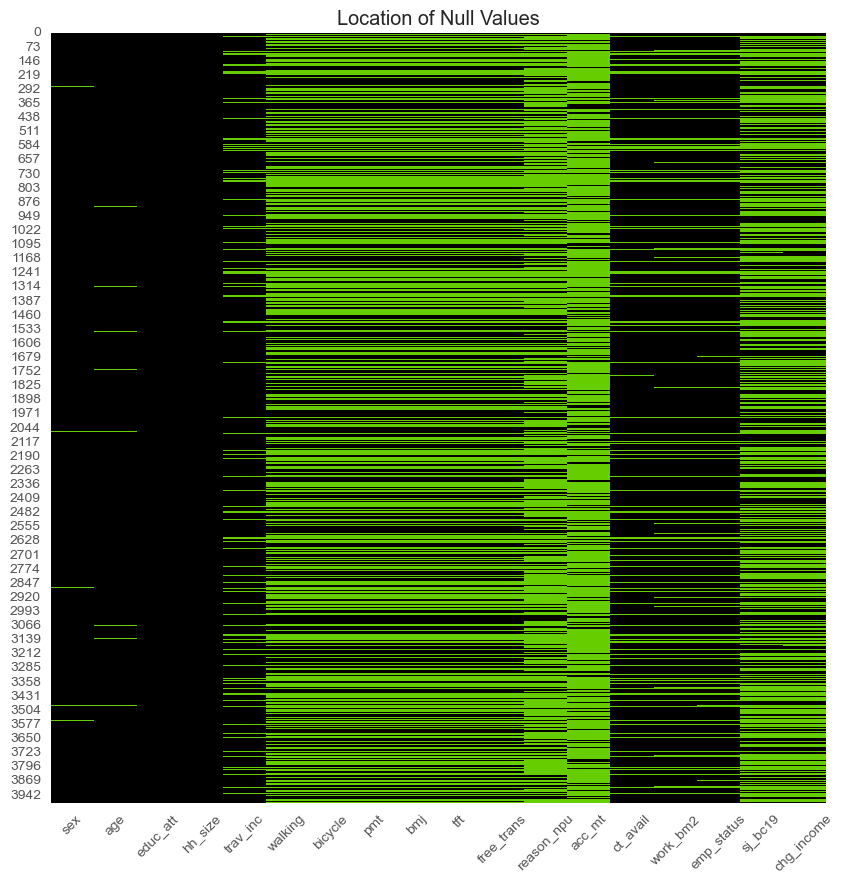

In [9]:
df_r1_ncr_na = df_r1_ncr.copy().reset_index(drop=True).isna()
fig_1, ax_1 = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax_1.set_title("Location of Null Values")
sns.heatmap(data=df_r1_ncr_na, ax=ax_1, cbar=False,
            cmap=sns.color_palette(["#000000", "#66CD00"]))
ax_1.tick_params(axis="x", rotation=45)

In [10]:
# na_array = []
# for column in df_r1_ncr.columns:
#     na_array.append(df_r1_ncr[column].isna().sum())
# df_r1_ncr_na = pd.DataFrame(
#     {
#         "null_values": na_array,
#         "column": df_r1_ncr.columns
#     }
# )
# df_r1_ncr_na = df_r1_ncr_na.sort_values(by="null_values", ascending=False).reset_index(drop=True)
# df_r1_ncr_na = df_r1_ncr_na.replace(columns=[])

In [11]:
df_r1_ncr.loc[(df_r1_ncr["work_bm2"] == 1) & (df_r1_ncr["emp_status"] == 2), "lost_job"] = 1
df_r1_ncr.loc[(df_r1_ncr["work_bm2"] == 2) & (df_r1_ncr["emp_status"] == 1), "lost_job"] = 0
df_r1_ncr.loc[(df_r1_ncr["work_bm2"] == 2) & (df_r1_ncr["emp_status"] == 2), "lost_job"] = 0
df_r1_ncr.loc[(df_r1_ncr["work_bm2"] == 1) & (df_r1_ncr["emp_status"] == 1), "lost_job"] = 0
# df_r1_ncr = df_r1_ncr.drop(columns=["trav_inc", "reason_npu", "work_bm2"])

In [12]:
for col in df_r1_ncr.columns:
    if col == "age":
        continue
    print(f"Value counts for {col}:")
    print(df_r1_ncr[col].value_counts(dropna=False).sort_index(), end= "\n\n")
    print("-------------------------------------------------------")

Value counts for sex:
sex
1.00    1506
2.00    2453
NaN       24
Name: count, dtype: int64

-------------------------------------------------------
Value counts for educ_att:
educ_att
1.00       1
2.00       1
3.00      17
4.00      25
5.00     132
6.00     394
7.00     219
8.00     839
9.00    2353
NaN        2
Name: count, dtype: int64

-------------------------------------------------------
Value counts for hh_size:
hh_size
1     165
2     439
3     655
4     818
5     706
6     432
7     298
8     190
9      94
10     73
11     41
12     21
13     11
14     14
15     10
16      3
17      3
18      1
20      3
24      1
25      5
Name: count, dtype: int64

-------------------------------------------------------
Value counts for trav_inc:
trav_inc
1.00    2026
2.00    1447
NaN      510
Name: count, dtype: int64

-------------------------------------------------------
Value counts for walking:
walking
0.00    1299
1.00     678
NaN     2006
Name: count, dtype: int64

------------------

In [13]:
df_r1_ncr.head()

,sex,age,educ_att,hh_size,trav_inc,walking,bicycle,pmt,bmj,tft,free_trans,reason_npu,acc_mt,ct_avail,work_bm2,emp_status,sj_bc19,chg_income,lost_job
0,1.00,32.00,9.00,2,1.00,1.00,0.00,0.00,0.00,0.00,0.00,5.00,NaN,1.00,1.00,1.00,1.00,2.00,0.00
1,2.00,50.00,9.00,7,1.00,0.00,0.00,0.00,0.00,1.00,0.00,NaN,2.00,1.00,1.00,1.00,1.00,2.00,0.00
2,2.00,49.00,9.00,5,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,NaN,2.00,2.00,2.00,NaN,NaN,0.00
3,2.00,33.00,9.00,2,1.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,1.00,1.00,1.00,1.00,1.00,3.00,0.00
4,2.00,27.00,8.00,4,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,2.00,1.00,1.00,1.00,3.00,0.00


## Pipeline for Encoding and Imputation

### Creating pipeline classes

#### Pipeline 1

In [14]:
np.random.seed(252)

class convert_code_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        b = x.copy()
        b.replace(
            {
                "sex": {1: 0, 2: 1},
                "educ_att": {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1},
                "acc_mt": {2: 0},
                "ct_avail": {2: 0, 3: -1},
                "work_bm2": {2: 0},
                "emp_status": {2: 0},
                "sj_bc19": {2: 0},
                "chg_income": {2: 0, 3: -1}
            }, inplace=True
        )
        return b

class binary_mode_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = 0
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = np.nan
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = np.nan
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = 1
        x.dropna(subset=["mode"], axis="index", inplace=True)
        x.drop(index=x.loc[x["acc_mt"] == 99].index, inplace=True)
        x.drop(index=x.loc[x["chg_income"] > 1].index, inplace=True)
        return x

class impute_na_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        impute_KNN = KNNImputer(n_neighbors=1)
        impute_KNN.fit(x[list(x.columns)])
        x[list(x.columns)] = impute_KNN.transform(x[list(x.columns)])
        return x 

class optimize_cols_1_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x["age"] = x["age"].apply(np.ceil)
        for col in x.columns:
            x[col] = x[col].astype(np.int32)
        return x
    
class drop_items_1_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.drop(columns=["trav_inc", "walking", "pmt", "bmj", "tft", "free_trans", "reason_npu", 
                        "work_bm2"], inplace=True)
        return x

class ohe_encoding_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        ohe = OneHotEncoder()
        array = ohe.fit_transform(x[["ct_avail", "chg_income"]]).toarray()
        col_names_1 = list(ohe.get_feature_names_out())
        for i in range(len(array.T)):
            x[col_names_1[i]] = array.T[i]
        return x
    
class optimize_cols_2_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        for col in x.columns:
            x[col] = x[col].astype(np.int32)
        x = x.rename(columns={"educ_att": "higher_educ"})
        return x
    
class drop_items_2_1(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.drop(columns=["ct_avail", "chg_income"], inplace=True)
        x.reset_index(drop=True, inplace=True)
        return x

#### Pipeline 2

In [15]:
np.random.seed(252)

class convert_code_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        b = x.copy()
        b.replace(
            {
                "sex": {1: 0, 2: 1},
                "educ_att": {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1},
                "acc_mt": {2: 0},
                "ct_avail": {2: 0, 3: -1},
                "work_bm2": {2: 0},
                "emp_status": {2: 0},
                "sj_bc19": {2: 0},
                "chg_income": {2: 0, 3: -1}
            }, inplace=True
        )
        return b

class binary_mode_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = 0
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = np.nan
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = np.nan
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = 1
        x.dropna(subset=["mode"], axis="index", inplace=True)
        x.drop(index=x.loc[x["acc_mt"] == 99].index, inplace=True)
        x.drop(index=x.loc[x["chg_income"] > 1].index, inplace=True)
        return x

class impute_na_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        impute_KNN = KNNImputer(n_neighbors=1)
        impute_KNN.fit(x[list(x.columns)])
        x[list(x.columns)] = impute_KNN.transform(x[list(x.columns)])
        return x 

class optimize_cols_1_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x["age"] = x["age"].apply(np.ceil)
        for col in x.columns:
            x[col] = x[col].astype(np.int32)
        x = x.rename(columns={"educ_att": "higher_educ"})
        return x
    
class drop_items_1_2(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.drop(columns=["trav_inc", "walking", "pmt", "bmj", "tft", "free_trans", "reason_npu", 
                        "work_bm2"], inplace=True)
        return x

#### Pipeline 3

In [16]:
np.random.seed(252)

class convert_code_3(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        b = x.copy()
        b.replace(
            {
                "sex": {1: 0, 2: 1},
                "educ_att": {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1},
                "acc_mt": {2: 0},
                "ct_avail": {2: 0, 3: -1},
                "work_bm2": {2: 0},
                "emp_status": {2: 0},
                "sj_bc19": {2: 0},
                "chg_income": {2: 0, 3: -1}
            }, inplace=True
        )
        return b

class binary_mode_3(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.drop(index=x.loc[x["acc_mt"] == 99].index, inplace=True)
        x.drop(index=x.loc[x["chg_income"] > 1].index, inplace=True)
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = 0
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 0) & (x["tft"] == 0) & (x["free_trans"] == 0)), "mode"] = np.nan
        x.loc[(x["pmt"] == 1) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = np.nan
        x.loc[(x["pmt"] == 0) & ((x["bmj"] == 1) | (x["tft"] == 1) | (x["free_trans"] == 1)), "mode"] = 1
        x.dropna(subset=["mode"], axis="index", inplace=True)
        return x

class impute_na_3(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        impute_KNN = KNNImputer(n_neighbors=1)
        impute_KNN.fit(x[list(x.columns)])
        x[list(x.columns)] = impute_KNN.transform(x[list(x.columns)])
        return x 

class optimize_cols_1_3(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x["age"] = x["age"].apply(np.ceil)
        for col in x.columns:
            x[col] = x[col].astype(np.int32)
        x = x.rename(columns={"educ_att": "higher_educ"})
        return x
    
class drop_items_1_3(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x.drop(columns=["trav_inc", "walking", "pmt", "bmj", "tft", "free_trans", "reason_npu", 
                        "work_bm2"], inplace=True)
        return x

### Creating pipelines

#### Pipeline 1

In [17]:
pipe_1 = Pipeline(
    [
        ("convert", convert_code_1()),
        ("mode", binary_mode_1()),
        ("impute", impute_na_1()),
        ("optimize 1", optimize_cols_1_1()),
        ("drop 1", drop_items_1_1()),
        ("ohe", ohe_encoding_1()),
        ("optimize 2", optimize_cols_2_1()),
        ("drop 2", drop_items_2_1())
    ]
)

#### Pipeline 2

In [18]:
pipe_2 = Pipeline(
    [
        ("convert", convert_code_2()),
        ("mode", binary_mode_2()),
        ("impute", impute_na_2()),
        ("optimize 1", optimize_cols_1_2()),
        ("drop 1", drop_items_1_2())
    ]
)

#### Pipeline 3

In [19]:
pipe_3 = Pipeline(
    [
        ("convert", convert_code_3()),
        ("mode", binary_mode_3()),
        ("impute", impute_na_3()),
        ("optimize 2", optimize_cols_1_3()),
        ("drop 2", drop_items_1_3())
    ]
)

### Application of pipelines into data

#### Pipeline 1

In [20]:
piped_df_1 = pipe_1.fit_transform(df_r1_ncr)

In [21]:
piped_df_1 = piped_df_1.rename(columns={"ct_avail_-1": "ct_avail_dk", "chg_income_-1": "chg_income_dec"})

In [22]:
piped_df_1.shape

(1493, 16)

In [23]:
df_y_1 = piped_df_1.copy()["mode"]
df_x_1 = piped_df_1.copy().drop(columns="mode").sort_index(axis="columns")
df_x_drp_1 = piped_df_1.copy().drop(columns=["ct_avail_0", "chg_income_0", "mode"]).sort_index(axis="columns")
piped_df_corr_1 = piped_df_1.copy().drop(columns=["ct_avail_0", "chg_income_0"]).sort_index(axis="columns")

In [24]:
for col in piped_df_1.columns:
    if col == "age":
        continue
    print(f"Value counts for {col}:")
    print(piped_df_1[col].value_counts(dropna=False).sort_index(), end= "\n\n")
    print("-------------------------------------------------------")

Value counts for sex:
sex
0    609
1    884
Name: count, dtype: int64

-------------------------------------------------------
Value counts for higher_educ:
higher_educ
0      20
1    1473
Name: count, dtype: int64

-------------------------------------------------------
Value counts for hh_size:
hh_size
1      67
2     191
3     225
4     312
5     260
6     159
7     104
8      71
9      40
10     28
11     13
12      6
13      2
14      4
15      4
16      2
17      1
18      1
20      2
25      1
Name: count, dtype: int64

-------------------------------------------------------
Value counts for bicycle:
bicycle
0    1414
1      79
Name: count, dtype: int64

-------------------------------------------------------
Value counts for acc_mt:
acc_mt
0     386
1    1107
Name: count, dtype: int64

-------------------------------------------------------
Value counts for emp_status:
emp_status
0    518
1    975
Name: count, dtype: int64

------------------------------------------------------

#### Pipeline 2

In [25]:
piped_df_2 = pipe_2.fit_transform(df_r1_ncr)

In [26]:
piped_df_2.shape

(1493, 12)

In [27]:
df_y_2 = piped_df_2.copy()["mode"]
df_x_2 = piped_df_2.copy().drop(columns="mode").sort_index(axis="columns")

In [28]:
for col in piped_df_2.columns:
    if col == "age":
        continue
    print(f"Value counts for {col}:")
    print(piped_df_2[col].value_counts(dropna=False).sort_index(), end= "\n\n")
    print("-------------------------------------------------------")

Value counts for sex:
sex
0    609
1    884
Name: count, dtype: int64

-------------------------------------------------------
Value counts for higher_educ:
higher_educ
0      20
1    1473
Name: count, dtype: int64

-------------------------------------------------------
Value counts for hh_size:
hh_size
1      67
2     191
3     225
4     312
5     260
6     159
7     104
8      71
9      40
10     28
11     13
12      6
13      2
14      4
15      4
16      2
17      1
18      1
20      2
25      1
Name: count, dtype: int64

-------------------------------------------------------
Value counts for bicycle:
bicycle
0    1414
1      79
Name: count, dtype: int64

-------------------------------------------------------
Value counts for acc_mt:
acc_mt
0     386
1    1107
Name: count, dtype: int64

-------------------------------------------------------
Value counts for ct_avail:
ct_avail
-1    490
 0    346
 1    657
Name: count, dtype: int64

----------------------------------------------

#### Pipeline 3

In [29]:
piped_df_3 = pipe_3.fit_transform(df_r1_ncr)

In [30]:
piped_df_3.shape

(1493, 12)

In [31]:
df_y_3 = piped_df_3.copy()["mode"]
df_x_3 = piped_df_3.copy().drop(columns="mode").sort_index(axis="columns")

In [32]:
for col in piped_df_3.columns:
    if col == "age":
        continue
    print(f"Value counts for {col}:")
    print(piped_df_3[col].value_counts(dropna=False).sort_index(), end= "\n\n")
    print("-------------------------------------------------------")

Value counts for sex:
sex
0    609
1    884
Name: count, dtype: int64

-------------------------------------------------------
Value counts for higher_educ:
higher_educ
0      20
1    1473
Name: count, dtype: int64

-------------------------------------------------------
Value counts for hh_size:
hh_size
1      67
2     191
3     225
4     312
5     260
6     159
7     104
8      71
9      40
10     28
11     13
12      6
13      2
14      4
15      4
16      2
17      1
18      1
20      2
25      1
Name: count, dtype: int64

-------------------------------------------------------
Value counts for bicycle:
bicycle
0    1414
1      79
Name: count, dtype: int64

-------------------------------------------------------
Value counts for acc_mt:
acc_mt
0     386
1    1107
Name: count, dtype: int64

-------------------------------------------------------
Value counts for ct_avail:
ct_avail
-1    490
 0    346
 1    657
Name: count, dtype: int64

----------------------------------------------

### Exploratory Data Analysis

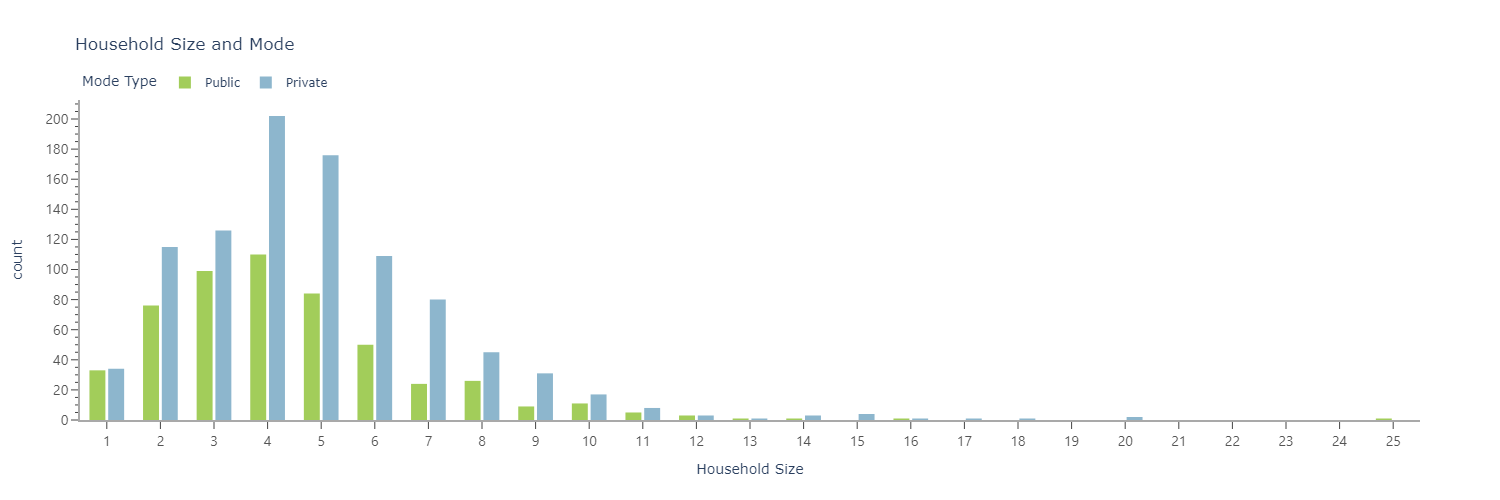

In [33]:
fig_1 = go.Figure()

fig_1 = px.histogram(data_frame=piped_df_2, x="hh_size", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Household Size and Mode", labels={"hh_size": "Household Size"})
fig_1.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_1.update_xaxes(nticks=40, ticklen=7)
fig_1.update_yaxes(nticks=15, ticklen=7, minor=dict(nticks=5, ticklen=3))

name_list_1=["Public", "Private"]
for i,trace in enumerate (fig_1.data):
  trace.update(name=name_list_1[i])

fig_1.show(renderer='png', width=1500, height=500)

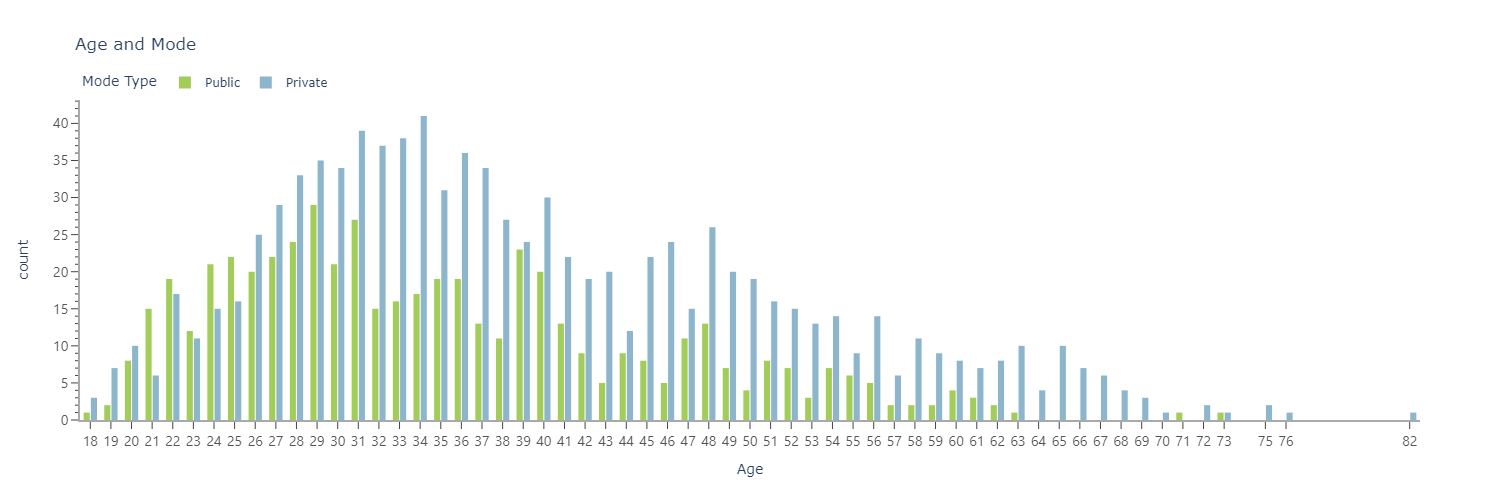

In [34]:
fig_2 = go.Figure()

fig_2 = px.histogram(data_frame=piped_df_2, x="age", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Age and Mode", labels={"age": "Age"}, width=1850)
fig_2.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3)

age_list = [age for age in piped_df_2["age"].unique()]
np.array(age_list).flatten()
fig_2.update_xaxes(rangemode="normal", tickmode="array", ticktext=age_list, tickvals=age_list, ticklen=7)
fig_2.update_yaxes(nticks=20, ticklen=7, minor=dict(nticks=5, ticklen=3))

name_list_2=["Public", "Private"]
for i,trace in enumerate (fig_2.data):
  trace.update(name=name_list_2[i])

fig_2.update_traces(nbinsx=120, selector=dict(type='histogram'))

fig_2.show(renderer='png', width=1500, height=500)

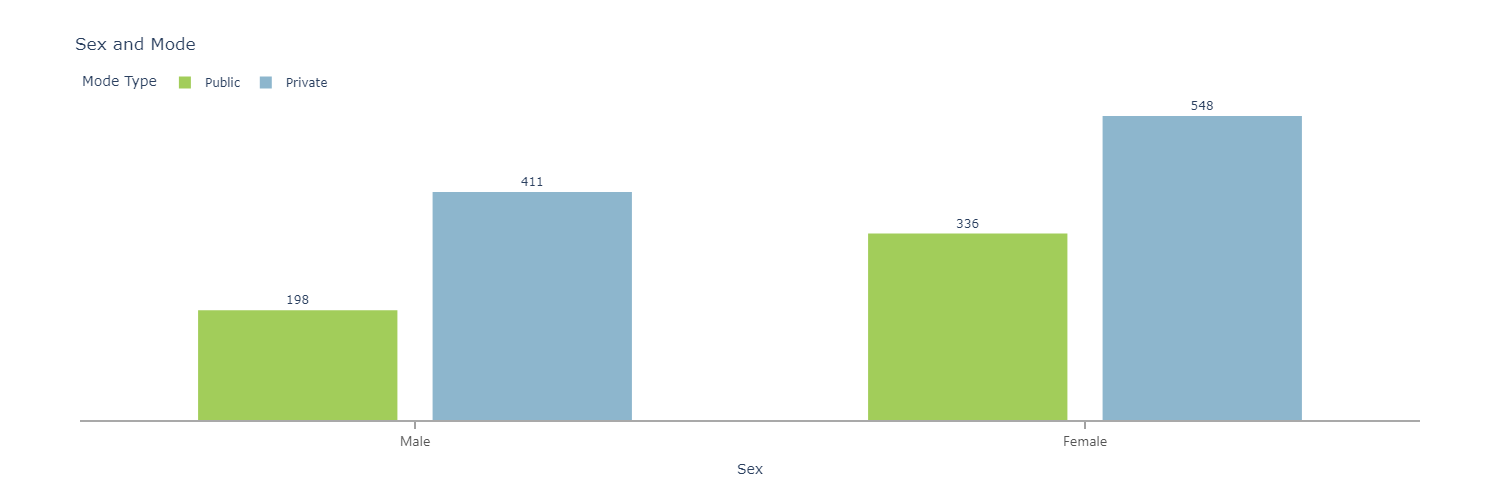

In [35]:
fig_3 = go.Figure()

fig_3 = px.histogram(data_frame=piped_df_2, x="sex", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Sex and Mode", labels={"sex": "Sex"}, text_auto=True)
fig_3.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_3.update_xaxes(ticklen=7, tickmode="array", ticktext=["Male", "Female"], tickvals=[0, 1])
fig_3.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_3=["Public", "Private"]
for i,trace in enumerate (fig_3.data):
  trace.update(name=name_list_3[i])

fig_3.update_traces(textposition="outside")

fig_3.show(renderer='png', width=1500, height=500)

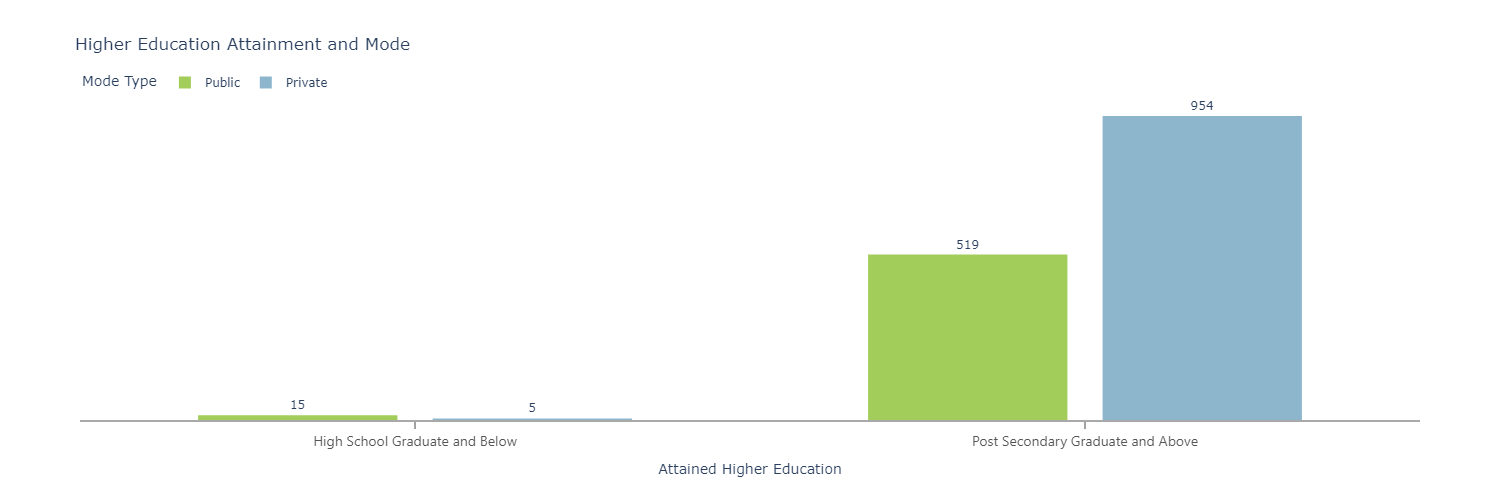

In [36]:
fig_4 = go.Figure()

fig_4 = px.histogram(data_frame=piped_df_2, x="higher_educ", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Higher Education Attainment and Mode", 
                     labels={"higher_educ": "Attained Higher Education"}, text_auto=True)
fig_4.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_4.update_xaxes(ticklen=7, tickmode="array", ticktext=["High School Graduate and Below", "Post Secondary Graduate and Above"], tickvals=[0, 1])
fig_4.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_4=["Public", "Private"]
for i,trace in enumerate (fig_4.data):
  trace.update(name=name_list_4[i])

fig_4.update_traces(textposition="outside")

fig_4.show(renderer='png', width=1500, height=500)

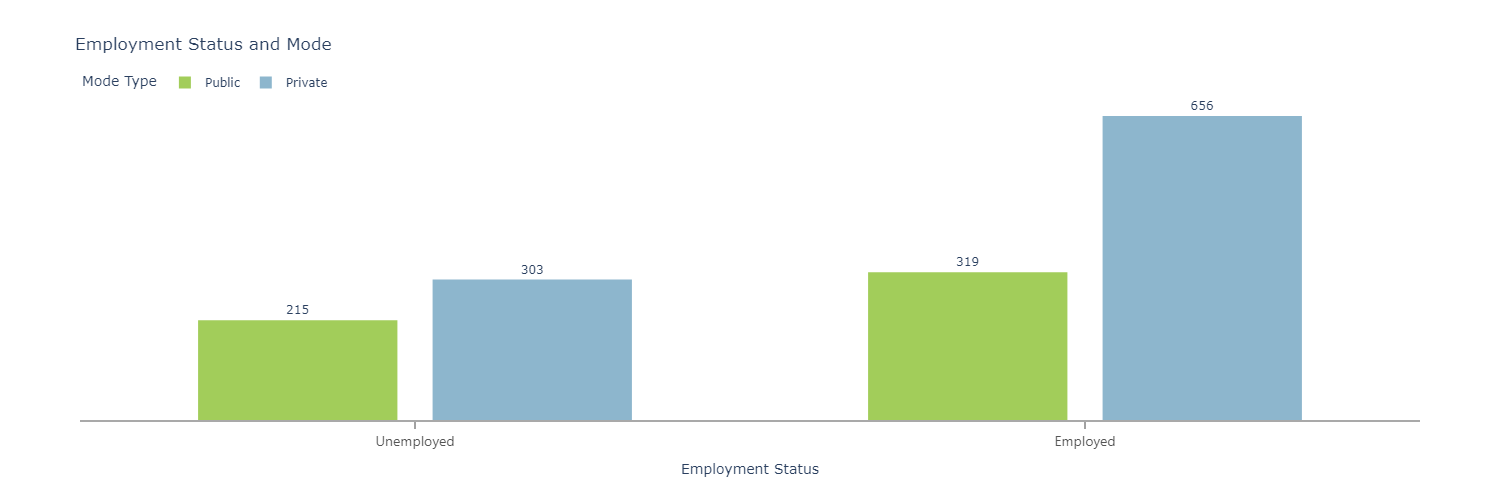

In [37]:
fig_5 = go.Figure()

fig_5 = px.histogram(data_frame=piped_df_2, x="emp_status", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Employment Status and Mode", 
                     labels={"emp_status": "Employment Status"}, text_auto=True)
fig_5.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_5.update_xaxes(ticklen=7, tickmode="array", ticktext=["Unemployed", "Employed"], tickvals=[0, 1])
fig_5.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_5=["Public", "Private"]
for i,trace in enumerate (fig_5.data):
  trace.update(name=name_list_5[i])

fig_5.update_traces(textposition="outside")

fig_5.show(renderer='png', width=1500, height=500)

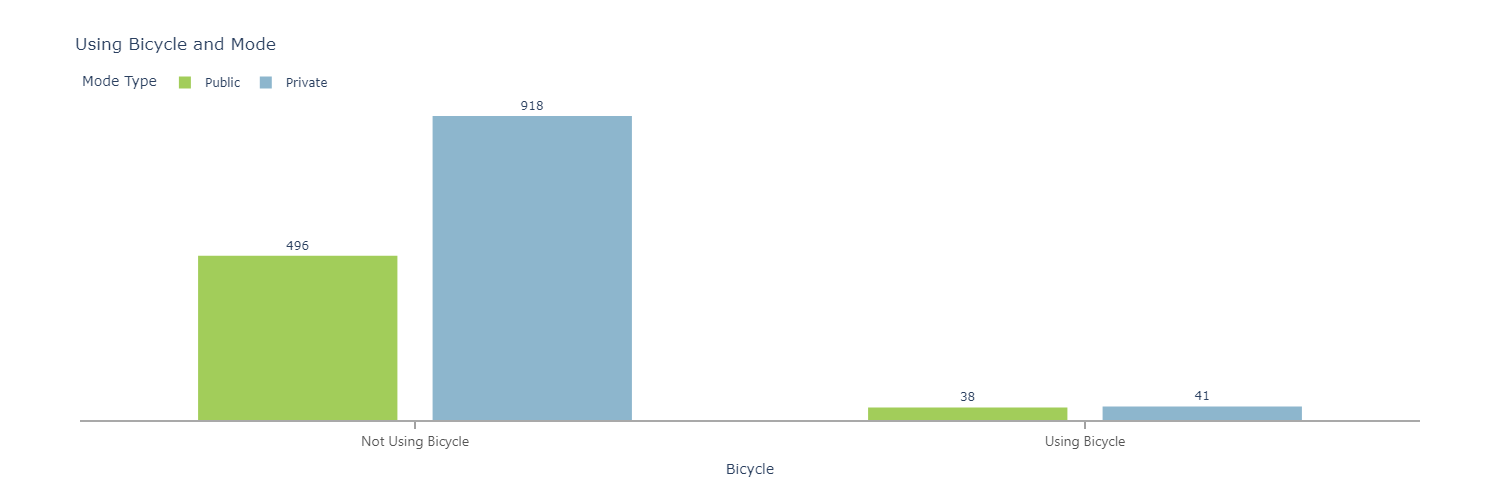

In [38]:
fig_6 = go.Figure()

fig_6 = px.histogram(data_frame=piped_df_2, x="bicycle", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Using Bicycle and Mode", 
                     labels={"bicycle": "Bicycle"}, text_auto=True)
fig_6.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_6.update_xaxes(ticklen=7, tickmode="array", ticktext=["Not Using Bicycle", "Using Bicycle"], tickvals=[0, 1])
fig_6.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_6=["Public", "Private"]
for i,trace in enumerate (fig_6.data):
  trace.update(name=name_list_6[i])

fig_6.update_traces(textposition="outside")

fig_6.show(renderer='png', width=1500, height=500)

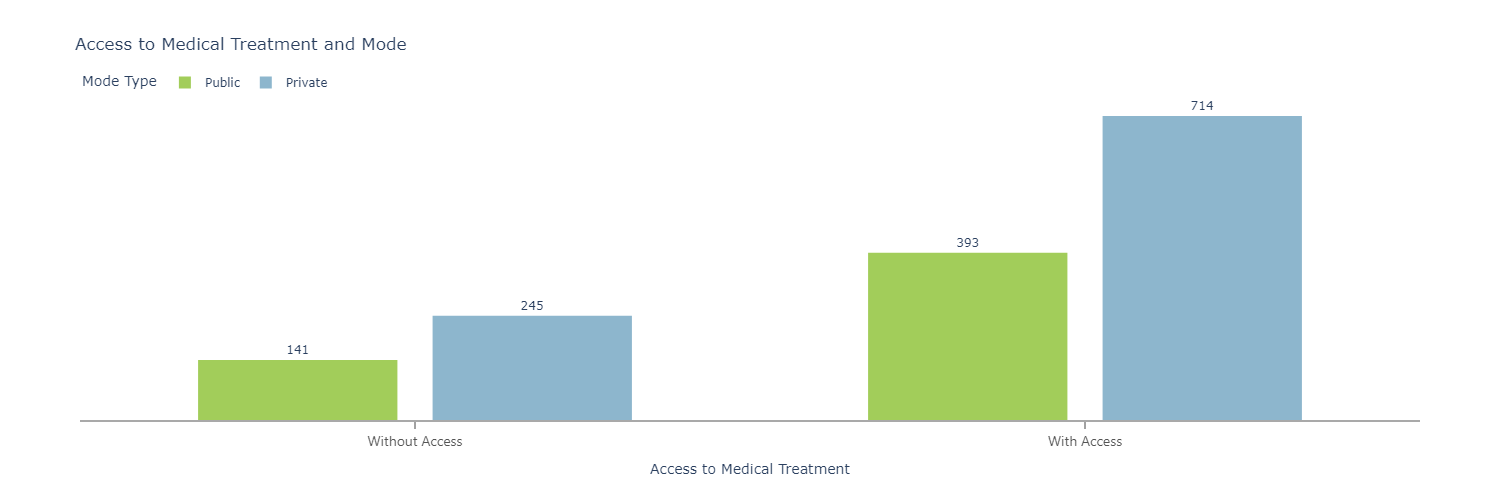

In [39]:
fig_7 = go.Figure()

fig_7 = px.histogram(data_frame=piped_df_2, x="acc_mt", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Access to Medical Treatment and Mode", 
                     labels={"acc_mt": "Access to Medical Treatment"}, text_auto=True)
fig_7.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_7.update_xaxes(ticklen=7, tickmode="array", ticktext=["Without Access", "With Access"], tickvals=[0, 1])
fig_7.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_7=["Public", "Private"]
for i,trace in enumerate (fig_7.data):
  trace.update(name=name_list_7[i])

fig_7.update_traces(textposition="outside")

fig_7.show(renderer='png', width=1500, height=500)

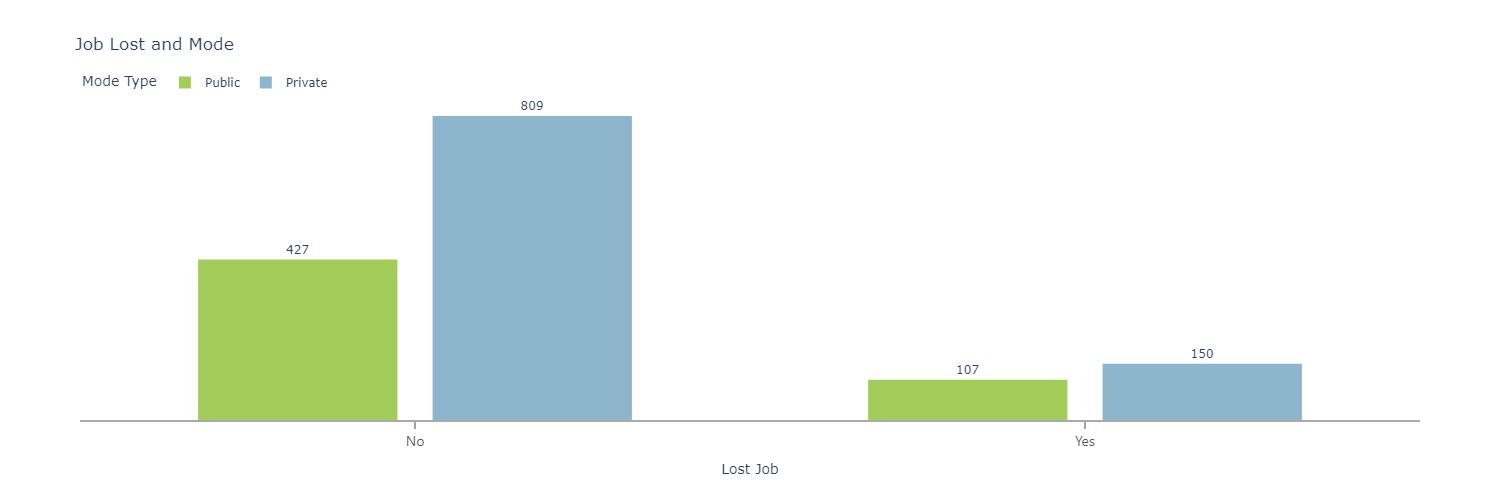

In [40]:
fig_8 = go.Figure()

fig_8 = px.histogram(data_frame=piped_df_2, x="lost_job", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Job Lost and Mode", 
                     labels={"lost_job": "Lost Job"}, text_auto=True)
fig_8.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_8.update_xaxes(ticklen=7, tickmode="array", ticktext=["No", "Yes"], tickvals=[0, 1])
fig_8.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_8=["Public", "Private"]
for i,trace in enumerate (fig_8.data):
  trace.update(name=name_list_8[i])

fig_8.update_traces(textposition="outside")

fig_8.show(renderer='png', width=1500, height=500)

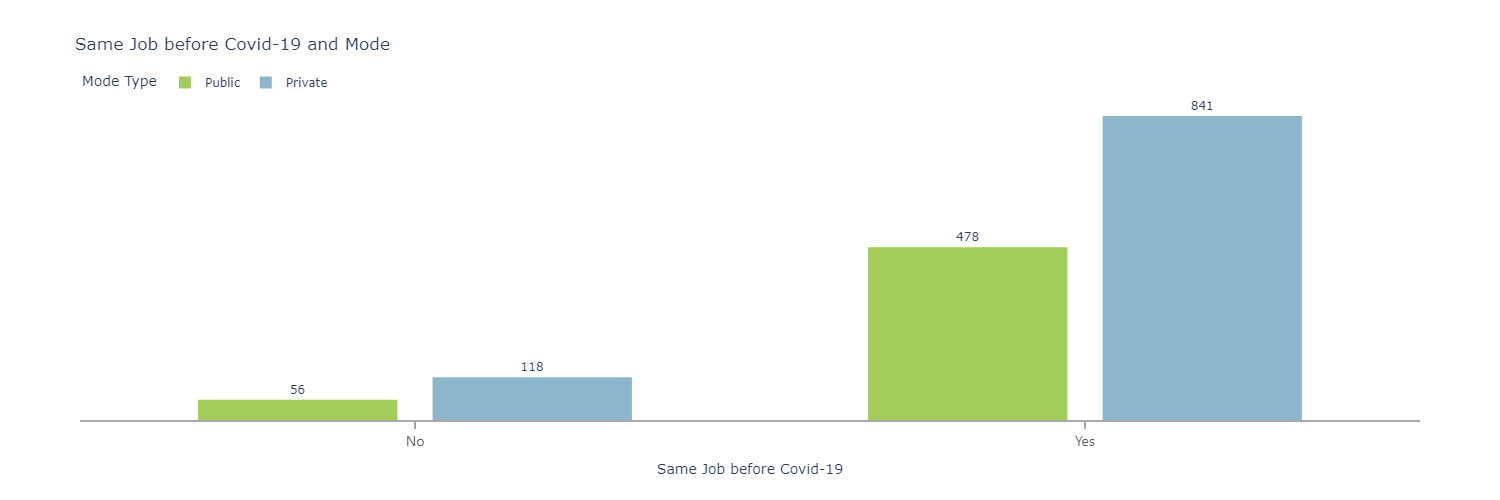

In [41]:
fig_9 = go.Figure()

fig_9 = px.histogram(data_frame=piped_df_2, x="sj_bc19", color="mode", color_discrete_map={0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Same Job before Covid-19 and Mode", 
                     labels={"sj_bc19": "Same Job before Covid-19"}, text_auto=True)
fig_9.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_9.update_xaxes(ticklen=7, tickmode="array", ticktext=["No", "Yes"], tickvals=[0, 1])
fig_9.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_9=["Public", "Private"]
for i,trace in enumerate (fig_9.data):
  trace.update(name=name_list_9[i])

fig_9.update_traces(textposition="outside")

fig_9.show(renderer='png', width=1500, height=500)

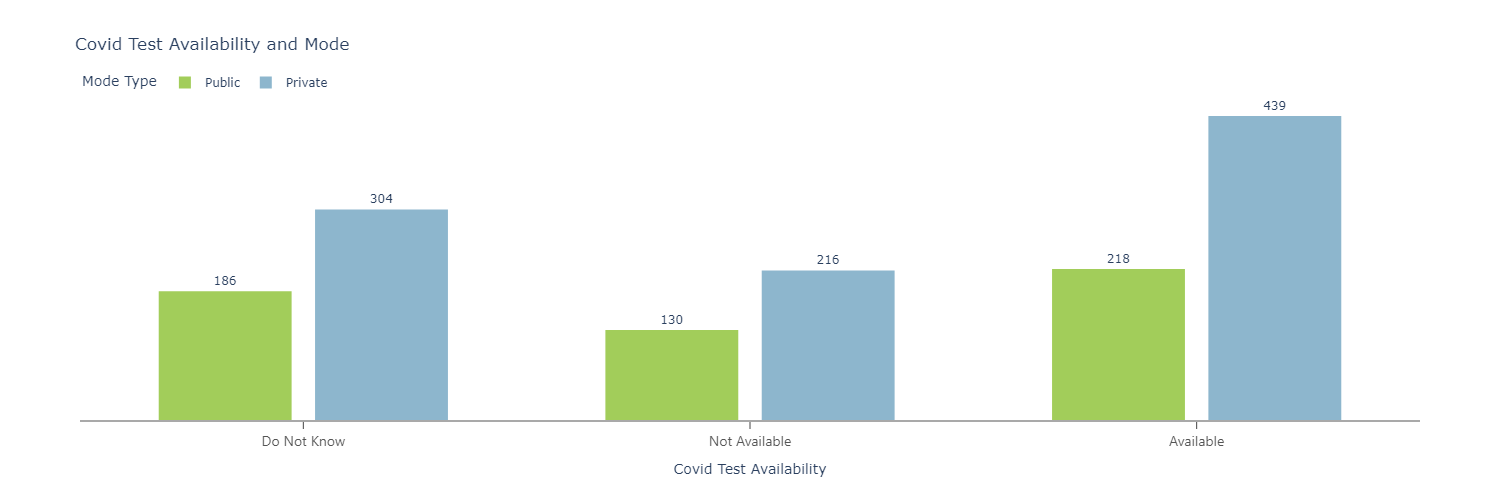

In [42]:
fig_10 = go.Figure()

fig_10 = px.histogram(data_frame=piped_df_2, x="ct_avail", color="mode", color_discrete_map={-1:"#EEAEEE", 0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Covid Test Availability and Mode", labels={"ct_avail": "Covid Test Availability"}, text_auto=True)
fig_10.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_10.update_xaxes(ticklen=7, tickmode="array", ticktext=["Do Not Know", "Not Available", "Available"], tickvals=[-1, 0, 1])
fig_10.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_10=["Public", "Private"]
for i,trace in enumerate (fig_10.data):
  trace.update(name=name_list_10[i])

fig_10.update_traces(textposition="outside")

fig_10.show(renderer='png', width=1500, height=500)

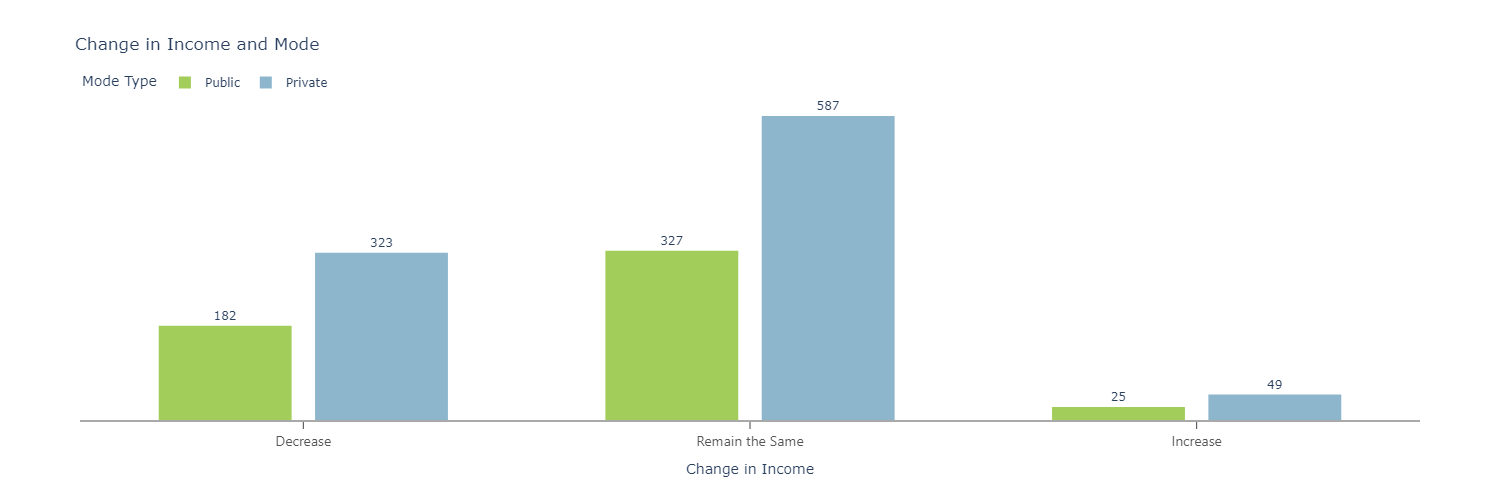

In [43]:
fig_11 = go.Figure()

fig_11 = px.histogram(data_frame=piped_df_2, x="chg_income", color="mode", color_discrete_map={-1:"#EEAEEE", 0: "#8DB6CD", 1: "#A2CD5A"},
                    barmode="group", title="Change in Income and Mode", labels={"chg_income": "Change in Income"}, text_auto=True)
fig_11.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#A9A9A9", linewidth=2, 
               ticks="outside", tickfont=dict(family="Nirmala UI", size=14, color="#545454")),
    plot_bgcolor="white", legend_title_text="Mode Type", legend_y=1.1,
    legend=dict(orientation="h"), bargroupgap=0.15, bargap=0.3, uniformtext_minsize=10)

fig_11.update_xaxes(ticklen=7, tickmode="array", ticktext=["Decrease", "Remain the Same", "Increase"], tickvals=[-1, 0, 1])
fig_11.update_yaxes(ticklen=0, showticklabels=False, visible=False)

name_list_11=["Public", "Private"]
for i,trace in enumerate (fig_11.data):
  trace.update(name=name_list_11[i])

fig_11.update_traces(textposition="outside")

fig_11.show(renderer='png', width=1500, height=500)

#### Visualizing correlation between variables

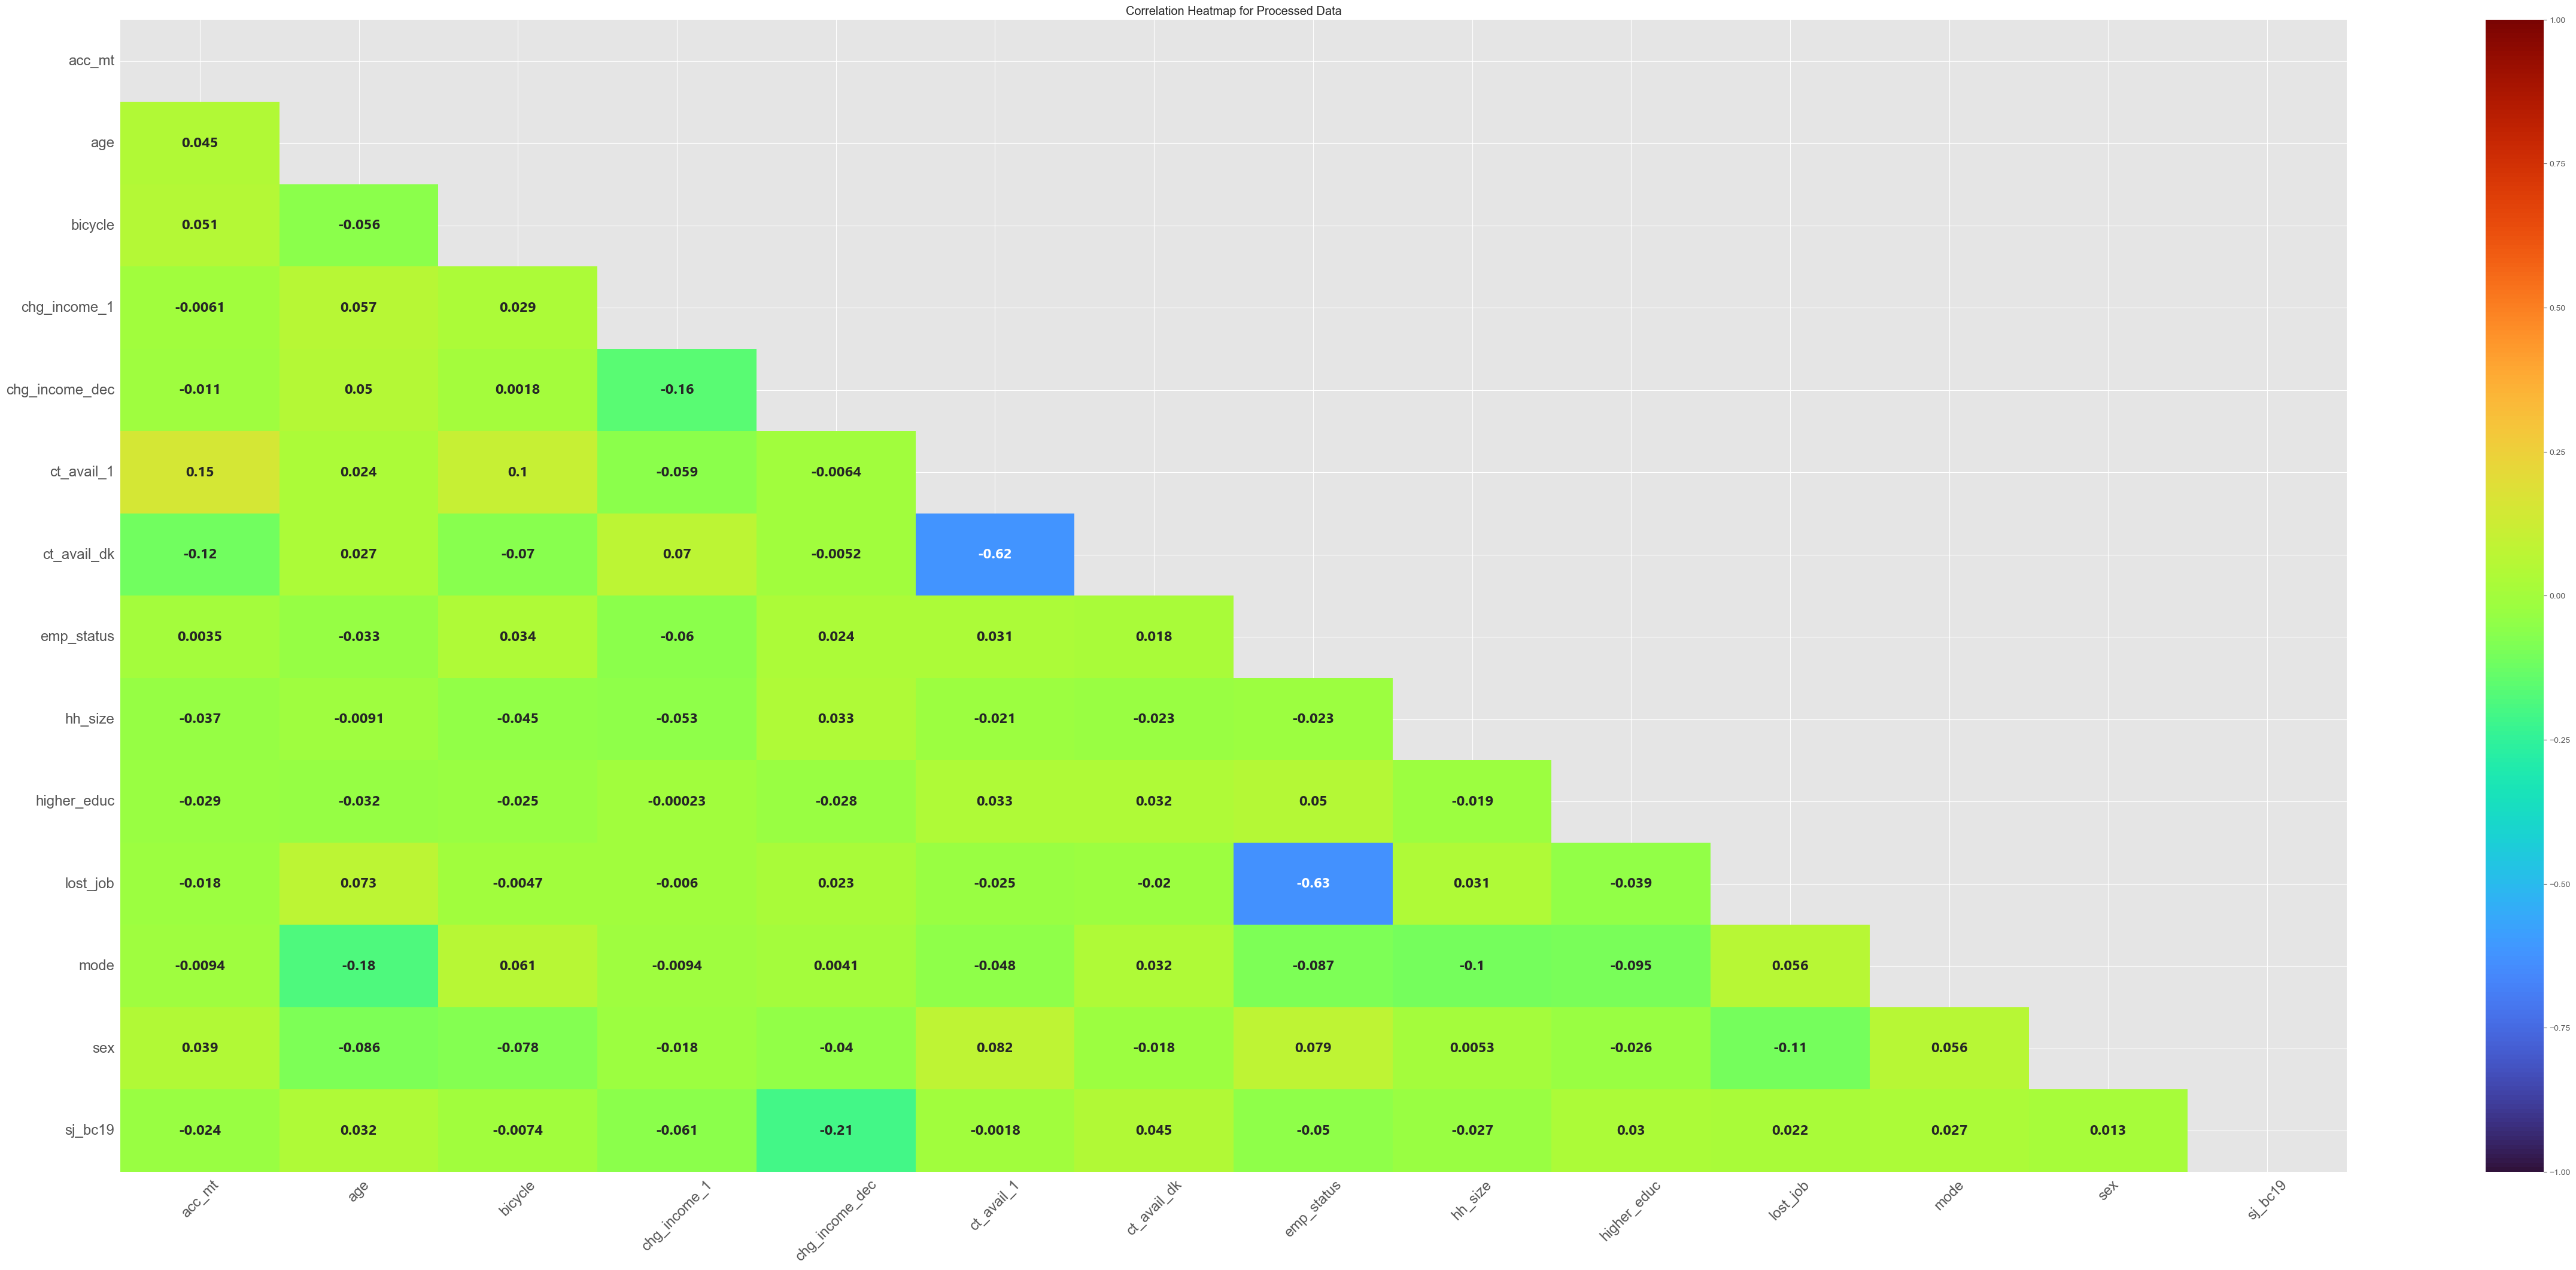

In [44]:
corr_piped_1 = piped_df_corr_1.corr(method="spearman")
corr_mask_piped_1 = np.triu(np.ones_like(corr_piped_1))

fig_12, ax_12 = plt.subplots(nrows=1, ncols=1, figsize=(60,25))
sns.heatmap(corr_piped_1, ax=ax_12, cmap="turbo", annot=True, vmin=-1, vmax=1, mask=corr_mask_piped_1,
           annot_kws=dict(fontfamily="Nirmala UI", fontsize="xx-large", fontweight="bold"))
ax_12.set_title("Correlation Heatmap for Processed Data")
ax_12.tick_params(axis="x", rotation=45, labelsize="xx-large")
ax_12.tick_params(axis="y", rotation=0, labelsize="xx-large")

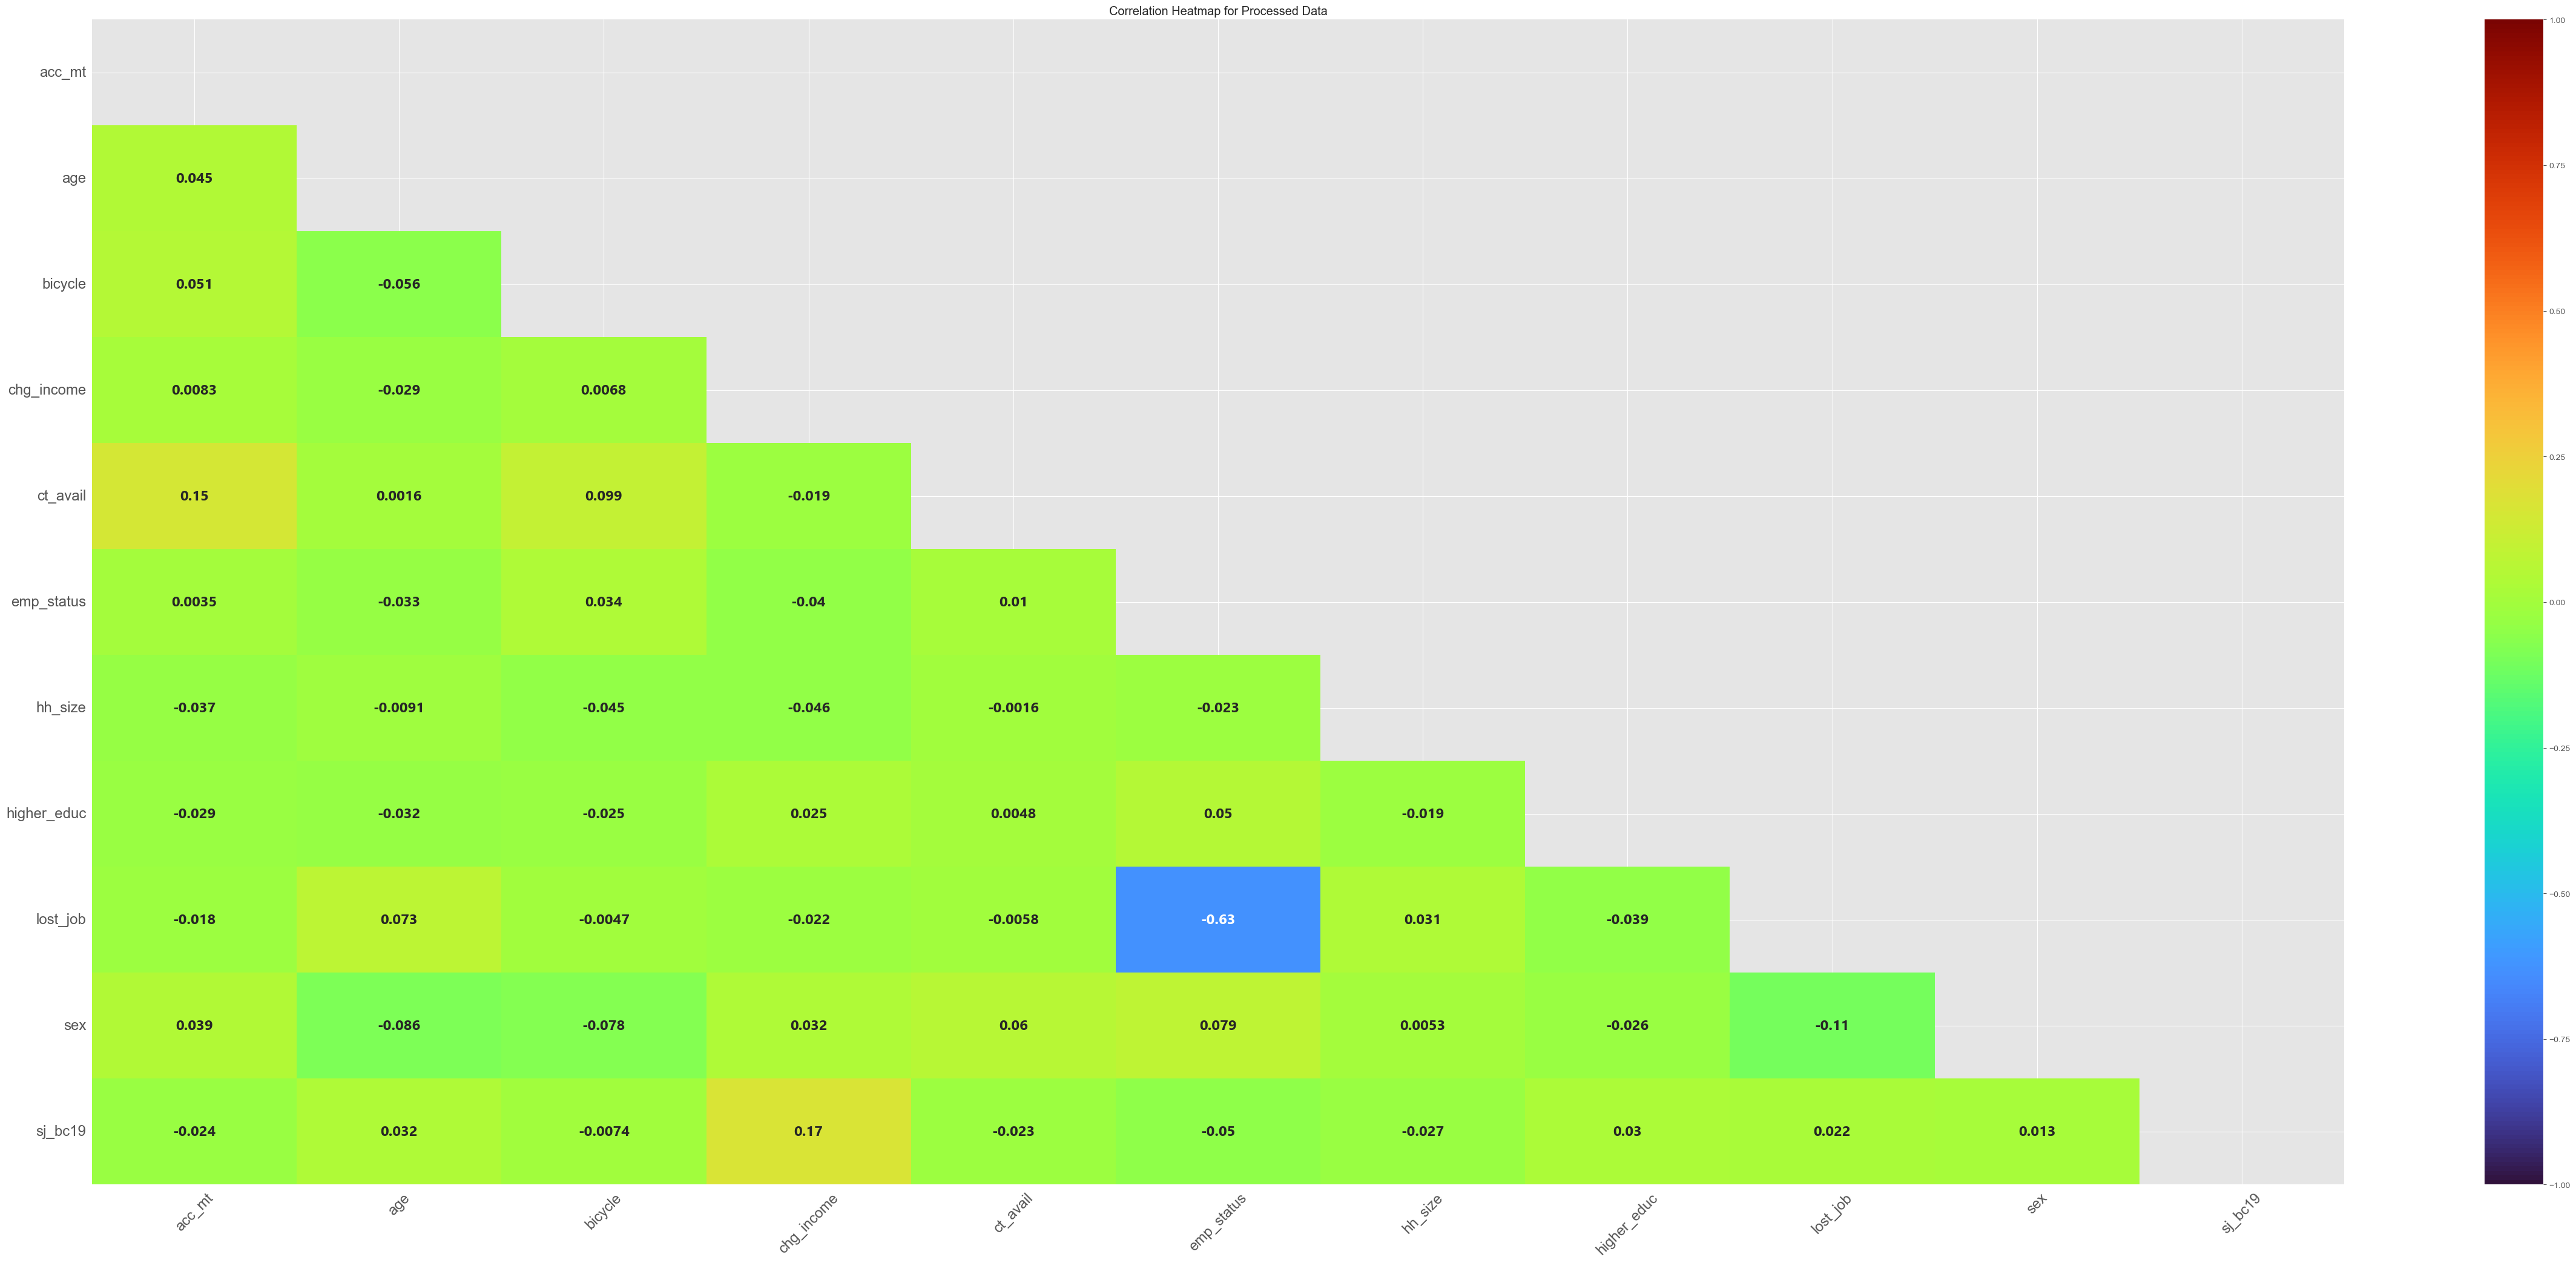

In [45]:
corr_piped_2 = df_x_2.corr(method="spearman")
corr_mask_piped_2 = np.triu(np.ones_like(corr_piped_2))

fig_13, ax_13 = plt.subplots(nrows=1, ncols=1, figsize=(60,25))
sns.heatmap(corr_piped_2, ax=ax_13, cmap="turbo", annot=True, vmin=-1, vmax=1, mask=corr_mask_piped_2,
           annot_kws=dict(fontfamily="Nirmala UI", fontsize="xx-large", fontweight="bold"))
ax_13.set_title("Correlation Heatmap for Processed Data")
ax_13.tick_params(axis="x", rotation=45, labelsize="xx-large")
ax_13.tick_params(axis="y", rotation=0, labelsize="xx-large")

### Saving processed dataframe into csv file

In [46]:
# piped_df_1.to_csv(r"C:\Users\User\Desktop\Files\Personal\Education\UP-SURP\Group Project\Plan 252A\Data\Discrete_Choice\r1_ncr_post_data_distinct_binary_revised_1.csv")
# piped_df_2.to_csv(r"C:\Users\User\Desktop\Files\Personal\Education\UP-SURP\Group Project\Plan 252A\Data\Discrete_Choice\r1_ncr_post_data_distinct_binary_revised_2.csv")

## Modeling using Logistic Regression

### Model 1

#### Hyperparameter tuning

In [47]:
params_logreg_GS_1 = {"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
logreg_GS_1 = LogisticRegression(random_state=252)
GS_logreg_1 = GridSearchCV(
    estimator=logreg_GS_1,
    cv=5,
    param_grid=params_logreg_GS_1,
    scoring="accuracy",
    refit="accuracy",
    verbose=4
)

#### Application of hypterparameter tuning

In [48]:
# GS_logreg_1.fit(df_x_drp_1, df_y_1)

In [49]:
# acc_GS_logreg_1 = round(GS_logreg_1.best_score_*100, 2)
# solver_GS_logreg_1 = GS_logreg_1.best_params_["solver"]
# print(f"Best parameter for Logistic Regression is a solver of {solver_GS_logreg_1} arriving at an average CV accuracy of {acc_GS_logreg_1}%")

#### Modeling Logistic Regression

In [50]:
best_logreg_1 = LogisticRegression(solver="lbfgs")
best_logreg_1.fit(df_x_drp_1, df_y_1)
predict_proba_1 = best_logreg_1.predict_proba(df_x_drp_1)
int_best_logreg_1 = best_logreg_1.intercept_[0]
best_logreg_index_1 = ["intercept"]
for col in best_logreg_1.feature_names_in_:
    best_logreg_index_1.append(col)
coeff_logreg_1 = pd.DataFrame({"Coefficient": best_logreg_1.coef_[0]}, index=df_x_drp_1.columns)
print("Resulting Coefficient for Logistic Regression")
print(coeff_logreg_1.sort_index(axis="index", ascending=True))
print(f"intercept:             {round(int_best_logreg_1, 4)}")

Resulting Coefficient for Logistic Regression
                Coefficient
acc_mt                -0.02
age                   -0.04
bicycle                0.50
chg_income_1          -0.04
chg_income_dec         0.08
ct_avail_1            -0.16
ct_avail_dk            0.10
emp_status            -0.41
hh_size               -0.09
higher_educ           -1.41
lost_job               0.11
sex                    0.24
sj_bc19                0.20
intercept:             2.5233


#### Model 1 results

In [51]:
logit_4_1 = logit("mode ~ sex + age + higher_educ + bicycle + acc_mt + emp_status \
                + sj_bc19 + lost_job + ct_avail_dk + ct_avail_1 + chg_income_dec \
                + chg_income_1", data=piped_df_1).fit()

Optimization terminated successfully.
         Current function value: 0.620014
         Iterations 5


In [52]:
logit_4_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   mode   No. Observations:                 1493
Model:                          Logit   Df Residuals:                     1480
Method:                           MLE   Df Model:                           12
Date:                Tue, 03 Sep 2024   Pseudo R-squ.:                 0.04915
Time:                        09:58:16   Log-Likelihood:                -925.68
converged:                       True   LL-Null:                       -973.53
Covariance Type:            nonrobust   LLR p-value:                 3.844e-15
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3867      0.623      3.833      0.000       1.166       3.607
sex                0.2412      0.117      2.068      0.039       0.013       0.470
age               -0.0370      0.005     -7.055      0.000      -0.047      -0.027
higher_educ       -1.7930      0.537     -3.338      0.001      -2.846      -0.740
bicycle            0.5592      0.244      2.289      0.022       0.080       1.038
acc_mt             0.0048      0.129      0.037      0.970      -0.248       0.257
emp_status        -0.3942      0.149     -2.648      0.008      -0.686      -0.102
sj_bc19            0.2477      0.183      1.351      0.177      -0.112       0.607
lost_job           0.1024      0.186      0.549      0.583      -0.263       0.468
ct_avail_dk        0.1221      0.151      0.808      0.419      -0.174       0.418
ct_avail_1        -0.1471      0.146     -1.008      0.313      -0.433       0.139
chg_income_dec     0.0897      0.123      0.731      0.465      -0.151       0.330
chg_income_1       0.0184      0.271      0.068      0.946      -0.512       0.549
==================================================================================
"""

### Model 2

#### Hyperparameter tuning

In [53]:
params_logreg_GS_2 = {"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
logreg_GS_2 = LogisticRegression(random_state=252)
GS_logreg_2 = GridSearchCV(
    estimator=logreg_GS_2,
    cv=5,
    param_grid=params_logreg_GS_2,
    scoring="accuracy",
    refit="accuracy",
    verbose=4
)

#### Application of hypterparameter tuning

In [54]:
# GS_logreg_2.fit(df_x_2, df_y_2)

In [55]:
# acc_GS_logreg_2 = round(GS_logreg_2.best_score_*100, 2)
# solver_GS_logreg_2 = GS_logreg_2.best_params_["solver"]
# print(f"Best parameter for Logistic Regression is a solver of {solver_GS_logreg_2} arriving at an average CV accuracy of {acc_GS_logreg_2}%")

#### Modeling Logistic Regression

In [56]:
best_logreg_2 = LogisticRegression(solver="newton-cg")
best_logreg_2.fit(df_x_2, df_y_2)
predict_proba_2 = best_logreg_2.predict_proba(df_x_2)
int_best_logreg_2 = best_logreg_2.intercept_[0]
best_logreg_index_2 = ["intercept"]
for col in best_logreg_2.feature_names_in_:
    best_logreg_index_2.append(col)
coeff_logreg_2 = pd.DataFrame({"Coefficient": best_logreg_2.coef_[0]}, index=df_x_2.columns)
print("Resulting Coefficient for Logistic Regression")
print(coeff_logreg_2.sort_index(axis="index", ascending=True))
print(f"intercept:          {round(int_best_logreg_2, 4)}")

Resulting Coefficient for Logistic Regression
             Coefficient
acc_mt             -0.01
age                -0.04
bicycle             0.49
chg_income         -0.07
ct_avail           -0.14
emp_status         -0.41
hh_size            -0.09
higher_educ        -1.45
lost_job            0.11
sex                 0.24
sj_bc19             0.20
intercept:          2.5421


In [57]:
# pd_logreg_1 = partial_dependence(best_logreg_2, df_x_2, features=[1], feature_names=['Age'], kind="average", grid_resolution=2)
# pd_logreg_1_plot = PartialDependenceDisplay.from_estimator(estimator=best_logreg_2, X=df_x_2, features=[1,2], categorical_features=[2])

#### Model 2 results

In [58]:
logit_4_2 = logit("mode ~ sex + age + higher_educ + bicycle + acc_mt + emp_status \
                + sj_bc19 + lost_job + ct_avail + chg_income", data=piped_df_2).fit()

Optimization terminated successfully.
         Current function value: 0.620055
         Iterations 5


In [59]:
logit_4_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   mode   No. Observations:                 1493
Model:                          Logit   Df Residuals:                     1482
Method:                           MLE   Df Model:                           10
Date:                Tue, 03 Sep 2024   Pseudo R-squ.:                 0.04909
Time:                        09:58:16   Log-Likelihood:                -925.74
converged:                       True   LL-Null:                       -973.53
Covariance Type:            nonrobust   LLR p-value:                 4.158e-16
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.4018      0.620      3.875      0.000       1.187       3.617
sex             0.2403      0.116      2.066      0.039       0.012       0.468
age            -0.0369      0.005     -7.072      0.000      -0.047      -0.027
higher_educ    -1.7970      0.535     -3.357      0.001      -2.846      -0.748
bicycle         0.5619      0.244      2.304      0.021       0.084       1.040
acc_mt          0.0033      0.129      0.026      0.980      -0.249       0.255
emp_status     -0.3973      0.149     -2.674      0.008      -0.689      -0.106
sj_bc19         0.2364      0.181      1.309      0.191      -0.118       0.590
lost_job        0.1005      0.186      0.540      0.589      -0.265       0.466
ct_avail       -0.1365      0.065     -2.089      0.037      -0.265      -0.008
chg_income     -0.0673      0.104     -0.649      0.516      -0.270       0.136
===============================================================================
"""

## Model 3

#### Hyperparameter tuning

In [60]:
params_rf_GS_1 = {'criterion': ['gini', 'entropy', 'log_loss'],
                     'max_features': [1,2,3,4,5,6,7,8,9,10,'sqrt', 'log2', None],
                     'max_samples' : [100, 300, 600, 900, 1000]}
rf_1 = RandomForestClassifier(bootstrap=True, random_state=252, verbose=4, n_estimators=1000)
GS_rf_1 = GridSearchCV(
    estimator=rf_1,
    cv=5,
    param_grid=params_rf_GS_1,
    scoring="accuracy",
    refit="accuracy",
    verbose=4
)

#### Application of hyperparameter tuning

In [61]:
# GS_rf_1.fit(df_x_2, df_y_2)

In [62]:
# acc_GS_rf_1 = round(GS_rf_1.best_score_*100, 2)
# criterion_GS_rf_1 = GS_rf_1.best_params_['criterion']
# maxfeat_GS_rf_1 = GS_rf_1.best_params_['max_features']
# max_samp_GS_rf_1 = GS_rf_1.best_params_['max_samples']
# print(f"Best parameter for Random Forest is a criterion of {criterion_GS_rf_1}, max features of {maxfeat_GS_rf_1} and {n_est_GS_rf_1} number of trees arriving at an average CV accuracy of {acc_GS_rf_1}%")

In [63]:
best_rf_1 = RandomForestClassifier(criterion='gini', max_features=5, n_estimators=100, random_state=252)
best_rf_1.fit(df_x_2, df_y_2)
predict_proba_3 = best_rf_1.predict_proba(df_x_2)
# for col in best_rf_1.feature_names_in_:
#     best_logreg_index_2.append(col)
# coeff_logreg_2 = pd.DataFrame({"Coefficient": best_logreg_2.coef_[0]}, index=df_x_2.columns)
# print("Resulting Coefficient for Logistic Regression")
# print(coeff_logreg_2.sort_index(axis="index", ascending=True))
# print(f"intercept:          {round(int_best_logreg_2, 4)}")

In [64]:
df_x_2.columns

Index(['acc_mt', 'age', 'bicycle', 'chg_income', 'ct_avail', 'emp_status',
       'hh_size', 'higher_educ', 'lost_job', 'sex', 'sj_bc19'],
      dtype='object')

In [65]:
df_x_2_fn = list(df_x_2.columns)

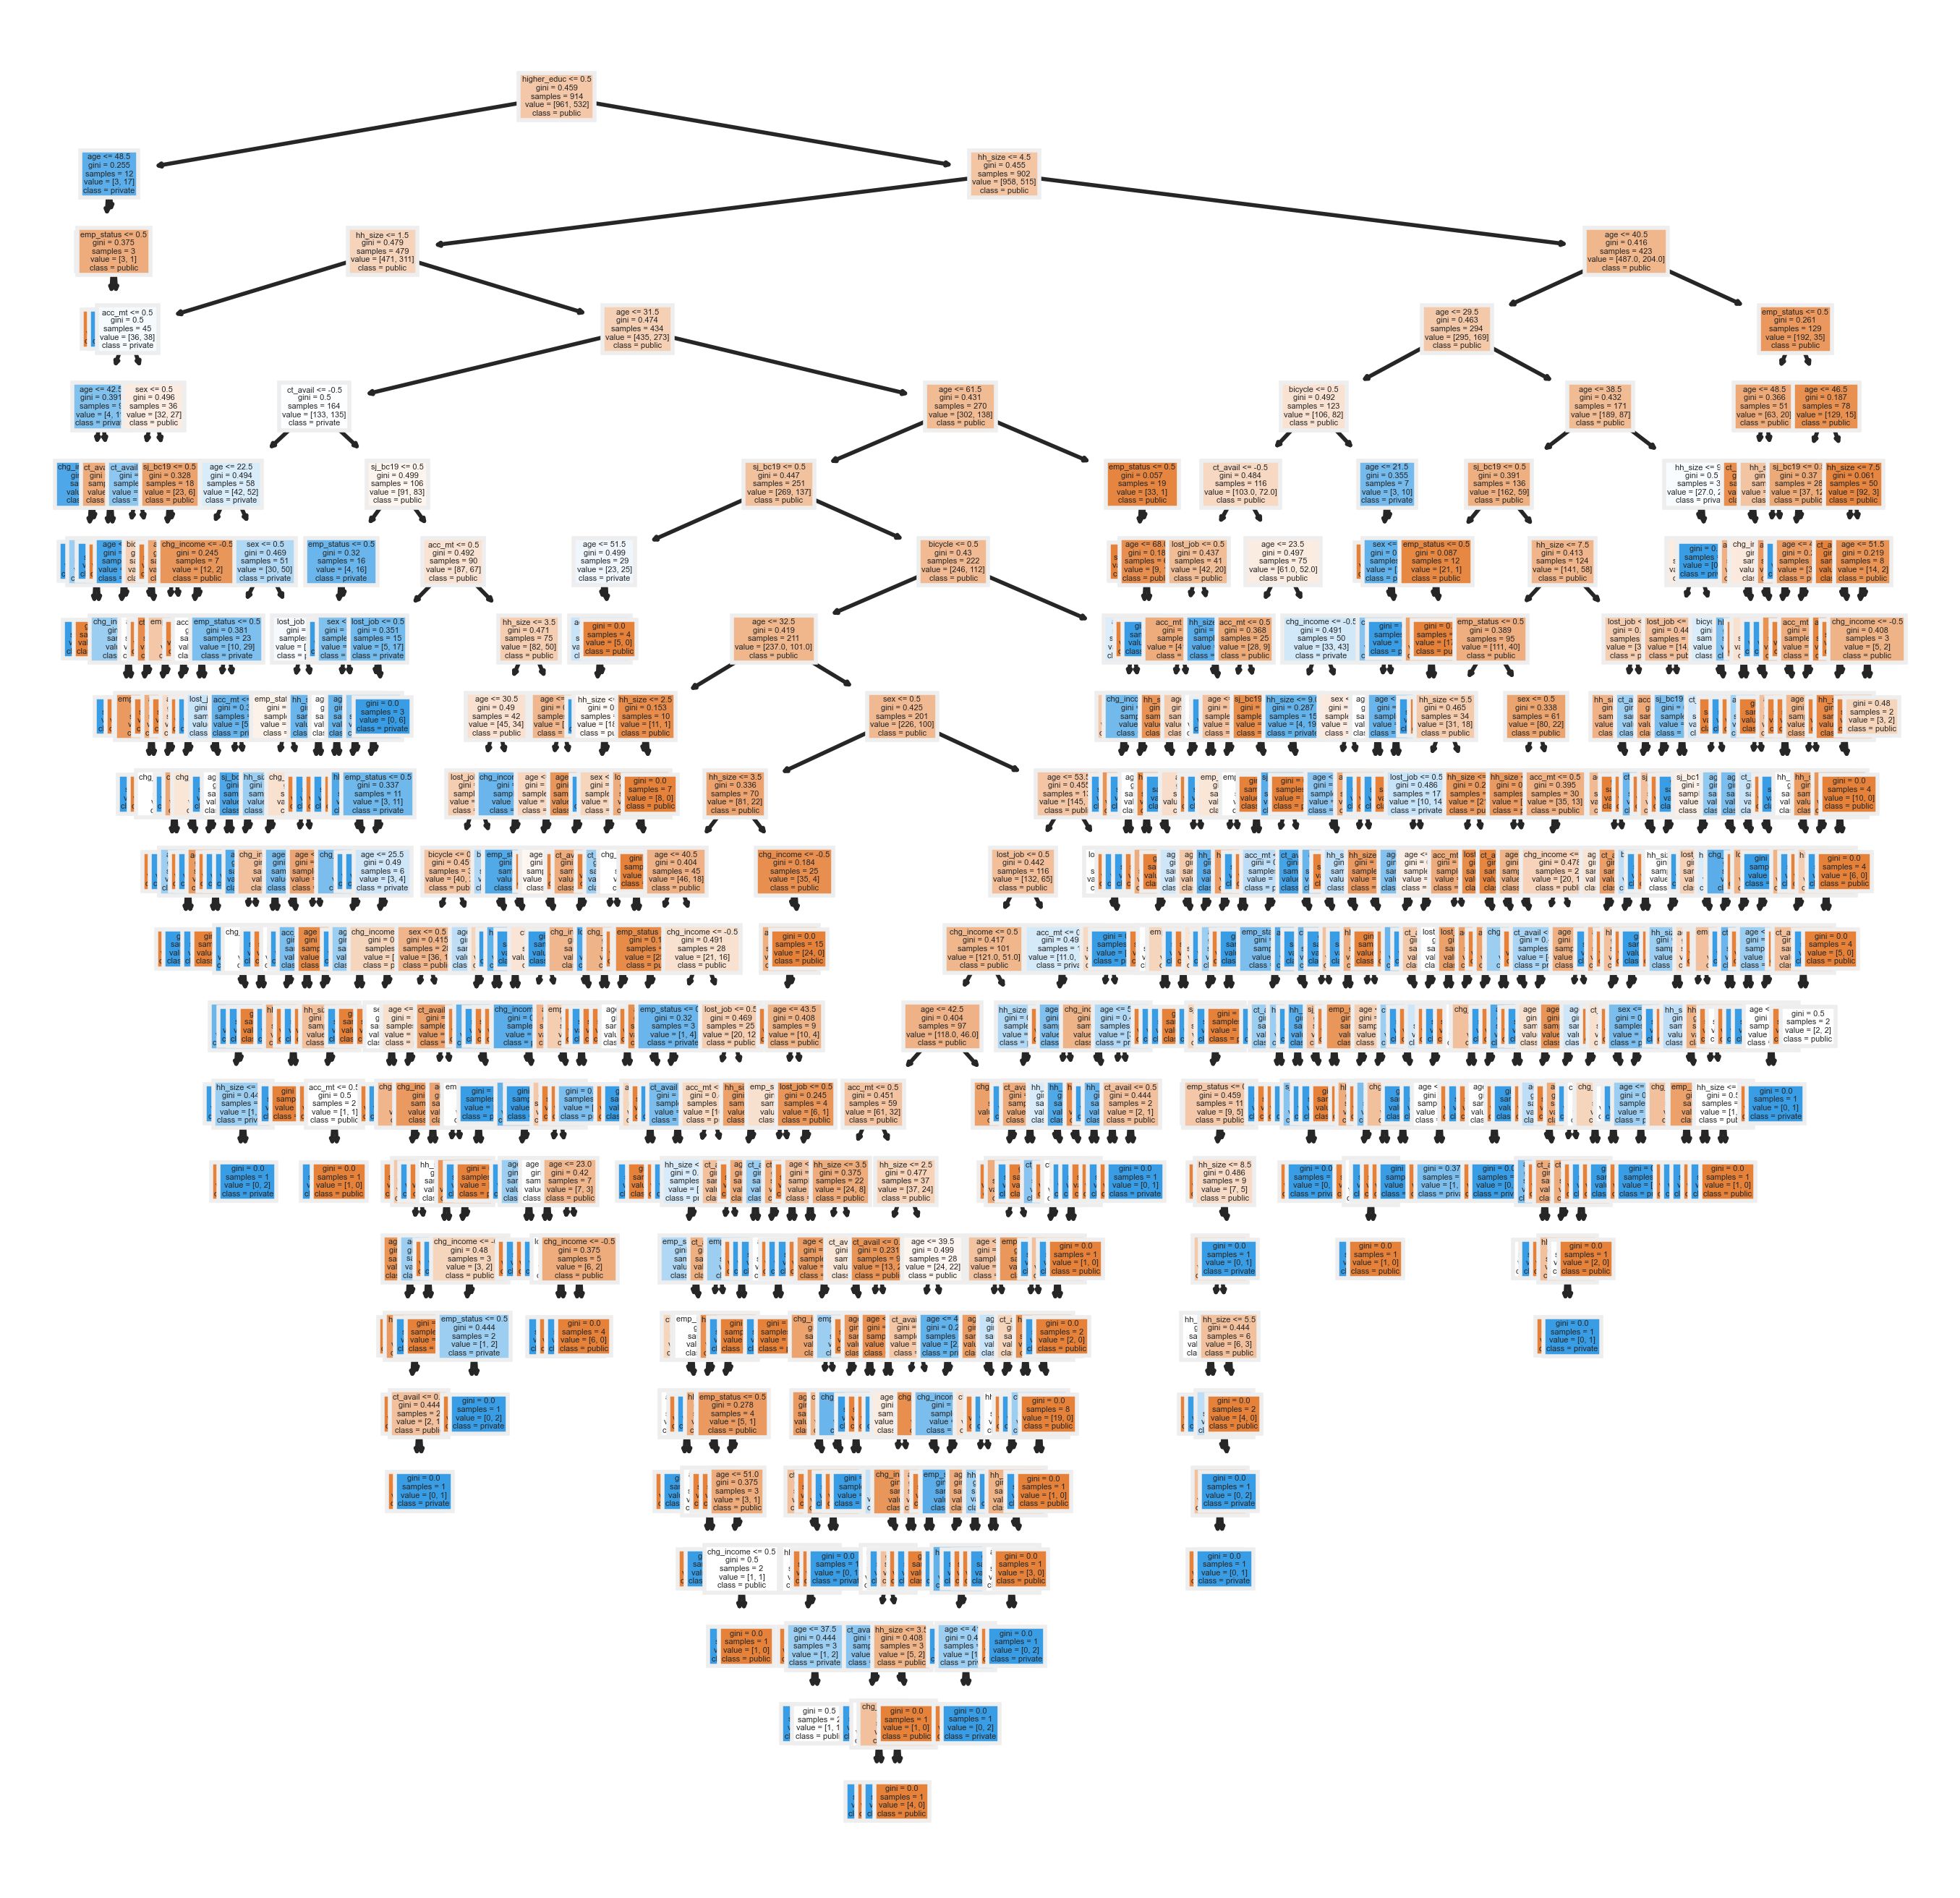

In [66]:
fig_13, ax_13 = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(best_rf_1.estimators_[0], feature_names = df_x_2_fn, class_names=['public', 'private'], filled = True)
fig_13.savefig('best_rf_1_tree.png')

In [67]:
df_y_2_rf = piped_df_2.copy().loc[(df_x_2['age'] > 20) & (df_x_2['age'] < 71)]["mode"].to_numpy()
df_x_2_rf = piped_df_2.copy().loc[(df_x_2['age'] > 20) & (df_x_2['age'] < 71)].drop(columns="mode").sort_index(axis="columns").to_numpy()

feat_names = ['Access', 'Age', 'Bicycle', 'Change Income',
              'Covid Test Availability', 'Employment Status',
              'Household Size', 'Higher Education', 'Lost Job',
              'Gender', 'Same Job before Covid-19']

grid_ale = np.sort(df_x_2['age'].unique())

In [68]:
pd_rf_1 = partial_dependence(estimator=best_rf_1, X=df_x_2, features=[1], 
                            kind="average", grid_resolution=80)

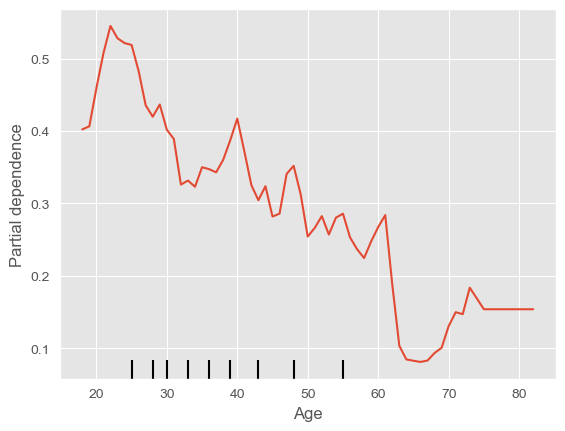

In [69]:
pd_rf_1_plot = PartialDependenceDisplay.from_estimator(estimator=best_rf_1, X=df_x_2, 
                                                       features=[1], feature_names=feat_names)

In [70]:
rf_ale = ALE(predictor=best_rf_1.predict, feature_names=feat_names, target_names=['Probability'])
lr_ale = ALE(predictor=best_logreg_2.predict, feature_names=feat_names, target_names=['Probability'])

In [71]:
rf_exp = rf_ale.explain(X=df_x_2_rf)#, grid_points={1:grid_ale})#, min_bin_points=1)
lr_exp = lr_ale.explain(X=df_x_2_rf)#, grid_points={1:grid_ale})#, min_bin_points=1)

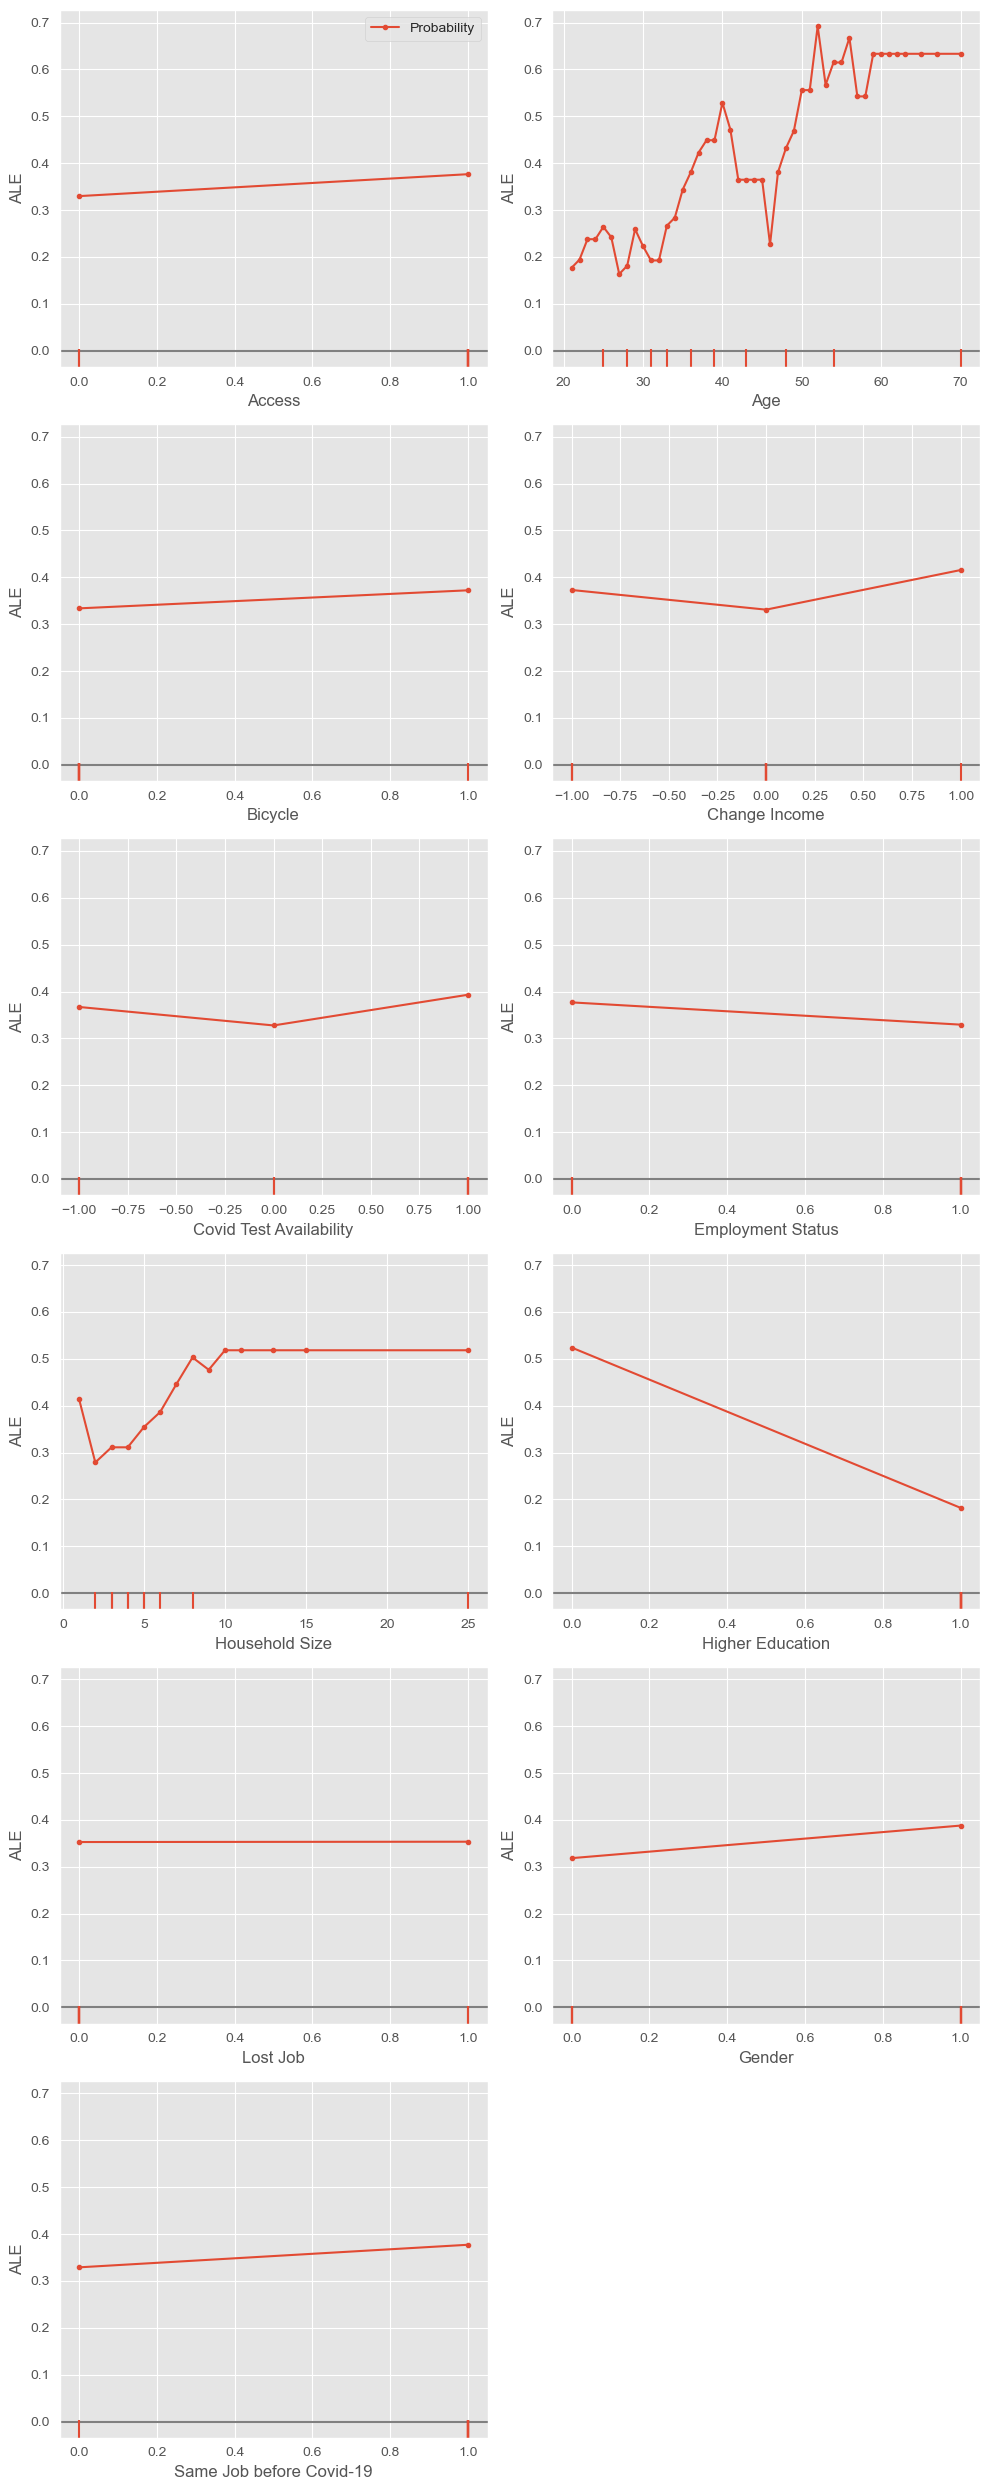

In [72]:
rf_ale_ax = plot_ale(exp=rf_exp, n_cols=2, constant=True, 
                     fig_kw={'figwidth':10, 'figheight': 25})

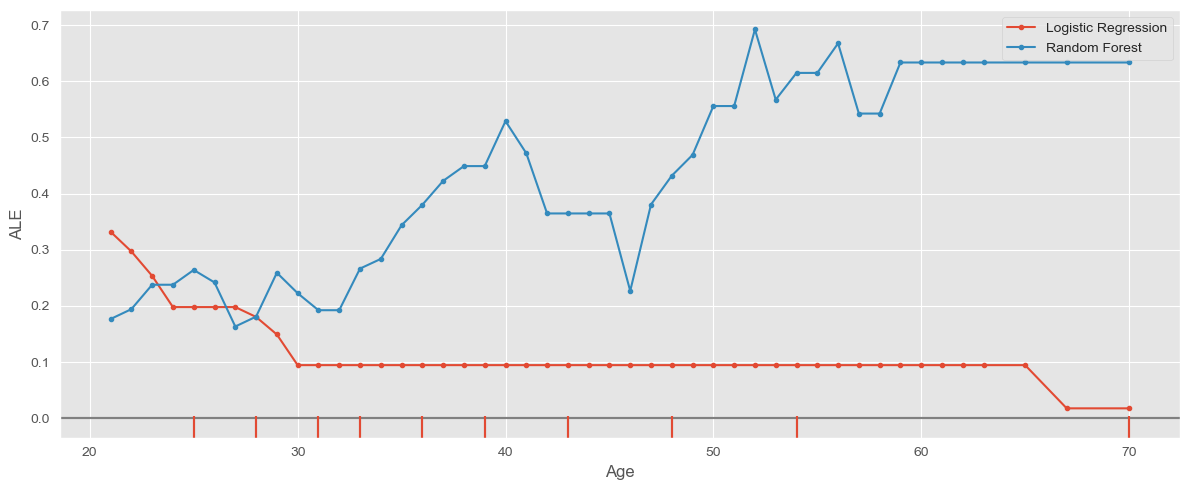

In [73]:
fig_15, ax_15 = plt.subplots()
lr_ale_ax = plot_ale(exp=lr_exp, features=[1], constant=True, 
                     fig_kw={'figwidth':10, 'figheight': 25}, 
                     line_kw={'label': 'Logistic Regression'}, ax=ax_15)

lr_ale_ax = plot_ale(exp=rf_exp, features=[1], constant=True, 
                     fig_kw={'figwidth':12, 'figheight': 5}, 
                     line_kw={'label': 'Random Forest'}, ax=ax_15)

In [74]:
predict_proba_rf_2 = best_rf_1.predict_proba(df_x_2.loc[(df_x_2['age'] > 20) & (df_x_2['age'] < 71)])

In [75]:
df_x_2_rf.shape

(1453, 11)

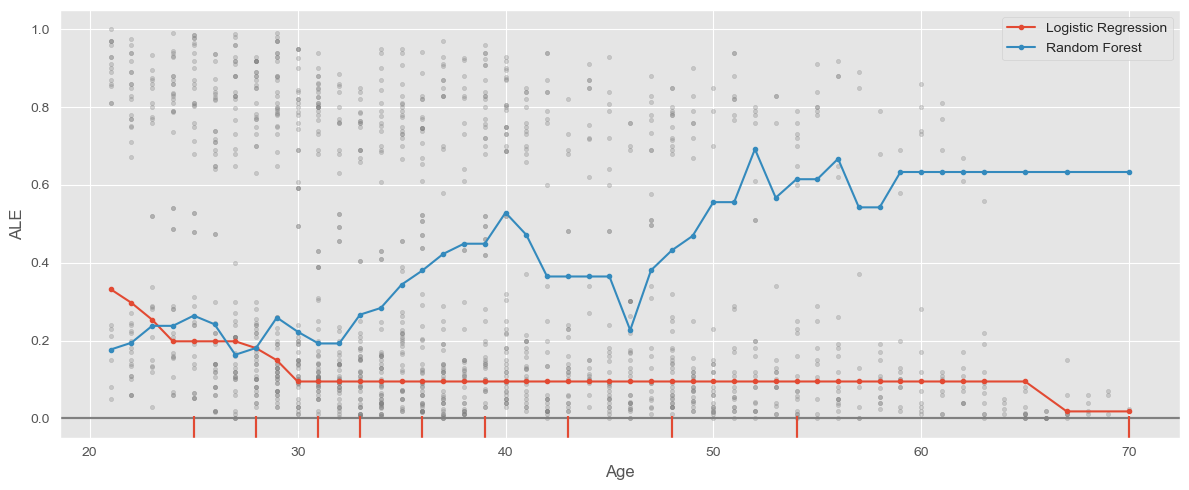

In [76]:
fig_15, ax_15 = plt.subplots()
lr_ale_ax = plot_ale(exp=lr_exp, features=[1], constant=True, 
                     fig_kw={'figwidth':10, 'figheight': 25}, 
                     line_kw={'label': 'Logistic Regression'}, ax=ax_15)

lr_ale_ax = plot_ale(exp=rf_exp, features=[1], constant=True, 
                     fig_kw={'figwidth':12, 'figheight': 5}, 
                     line_kw={'label': 'Random Forest'}, ax=ax_15)

ax_15.scatter(df_x_2_rf[:, 1], predict_proba_rf_2[:, 1], marker = '.', color = 'gray', alpha = 0.3)